# EDA + Timeseries analysis with SARIMA, RF or XGBoost

## Notebook summary
The data is about household energy consumption. We have several indicators like global active power, global intensity, ...

In the preprocessing, we've corrected the datatypes and imputed the missing values with interpolation.

The analysis will focus on the target Global Active Power, this variable represents the global minute-averaged active power (in kilowatt). The variable distribution is highly skew, and over the year we can see that the warm months have less energy consumption, than colder months. It´s also notable a daily seasonality, with 2 main peaks one in the morning and one by the end of the day.

To reduce noise in the measurements, we will average Global active power, with in the months of the different years.

Despite the result of the ADF that indicates that stationary, the plots expose some trends and seasonality. So, to make this stationary, we'll need seasonal differencing.

The dataset was split with 90% for training and 10% for testing, because of computational constrains, since the training with SARIMA takes too long.

With SARIMA we did a rolling forecast, with time window of 1 hour, to improve predictions for the next day. In the case of RF and XGBoost we created some time related features with the ´tsfresh´ library.

The results for we predictions look similar but the predictions with SARIMA had less error overall. The model predictions for the next hour (real value: 1.486 kW) were:
- SARIMA: 1.407 kW
- RF: 1.469 kW
- XGBoost: 1.469 kW

The model metrics:
- SARIMA:
    - RMSE: 0.098
    - MAE: 0.217
    - MAPE: 22.22%
- Random Forest:
    - RMSE: 0.400
    - MAE: 0.301
    - MAPE: 25.40%
- XGBoost:
    - RMSE: 0.400
    - MAE: 0.301
    - MAPE: 25.40%

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute, make_forecasting_frame
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Data loading

In [2]:
df = pd.read_csv('../Datasets/household_power_consumption.txt', sep=';')
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('Datetime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)
df.head()

C:\Users\dcavalei\AppData\Local\Temp\ipykernel_22280\3683538455.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Datasets/household_power_consumption.txt', sep=';')


Global_active_power Global_reactive_power  Voltage  \
Datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
Datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

## Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


Correct the dtypes that should be numeric

In [4]:
object_cols= df.select_dtypes(include=['object']).columns
object_cols

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2'],
      dtype='object')

In [5]:
df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')

In [6]:
len(df)

2075259

In [7]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

### NaN impute

In [8]:
df.interpolate(method='time', inplace=True) #fill nan with interpolation

In [9]:
hourly_df = df.resample('H').agg('mean') # group by
hourly_df

C:\Users\dcavalei\AppData\Local\Temp\ipykernel_22280\3406481787.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample('H').agg('mean') # group by


Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-16 21:00:00         13.046667             0.0        0.416667   
...                               ...             ...             ...   
2010-11-26 17:00:00          7.216667             0.0        0.000000   
2010-11-26 18:00:00          6.620000             0.0        0.000000   
2010-11-26 19:00:00          7.056667             0.0        0.066667   
2010-11-26 20:00:00          4.913333             0.0        1.066667   
2010-11-26 21:00:00          3.800000             0.0        0.000000   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:00:00       16.861111  
2006-12-16 18:00:00       16.866667  
2006-12-16 19:00:00       16.683333  
2006-12-16 20:00:00       16.783333  
2006-12-16 21:00:00       17.216667  
...                             ...  
2010-11-26 17:00:00       12.866667  
2010-11-26 18:00:00        0.000000  
2010-11-26 19:00:00        0.000000  
2010-11-26 20:00:00        0.000000  
2010-11-26 21:00:00        0.000000  

[34589 rows x 7 columns]

In [10]:
hourly_df[hourly_df == '?'].sum()

Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64

In [11]:
hourly_df.duplicated().sum()

np.int64(4)

In [12]:
hourly_df[hourly_df.duplicated()]

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2008-10-06 12:00:00                 0.36                  0.078   241.18   
2008-10-06 13:00:00                 0.36                  0.078   241.18   
2008-10-06 14:00:00                 0.36                  0.078   241.18   
2008-10-06 15:00:00                 0.36                  0.078   241.18   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2008-10-06 12:00:00               1.6             0.0             0.0   
2008-10-06 13:00:00               1.6             0.0             0.0   
2008-10-06 14:00:00               1.6             0.0             0.0   
2008-10-06 15:00:00               1.6             0.0             0.0   

                     Sub_metering_3  
Datetime                             
2008-10-06 12:00:00             1.0  
2008-10-06 13:00:00             1.0  
2008-10-06 14:00:00             1.0  
2008-10-06 15:00:00             1.0

In [13]:
# check for missing values
hourly_df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# Statistical analysis

In [14]:
corr_matrix = hourly_df.corr()

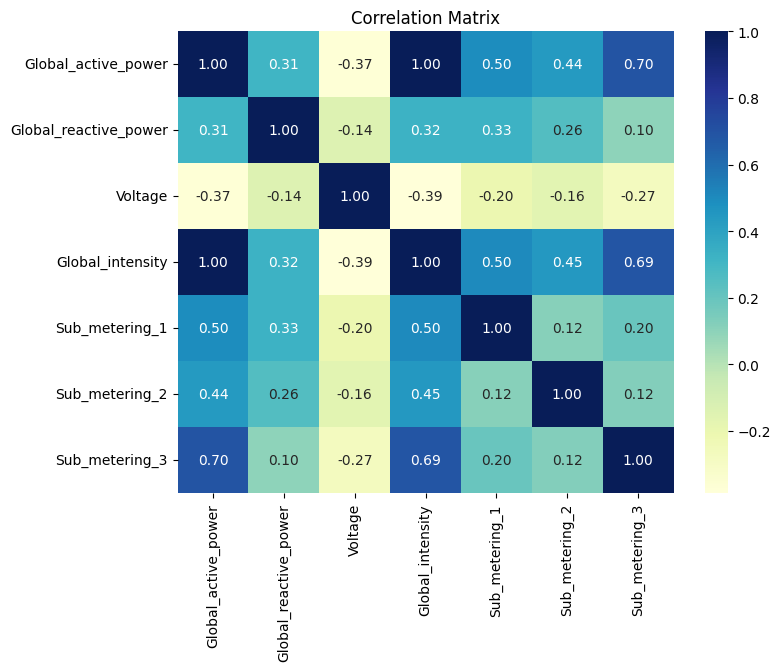

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

global active (household global minute-averaged active power (in kilowatt)) and global intensity (household global minute-averaged current intensity (in ampere)) represent the same.

In [16]:
hourly_df.describe().T

count        mean       std         min         25%  \
Global_active_power    34589.0    1.090311  0.894323    0.124000    0.342867   
Global_reactive_power  34589.0    0.123647  0.067072    0.000000    0.077933   
Voltage                34589.0  240.832682  3.001576  225.834500  239.178167   
Global_intensity       34589.0    4.621615  3.743583    0.503333    1.516667   
Sub_metering_1         34589.0    1.109442  3.518391    0.000000    0.000000   
Sub_metering_2         34589.0    1.289185  4.168299    0.000000    0.000000   
Sub_metering_3         34589.0    6.442329  7.340881    0.000000    0.650000   

                              50%         75%         max  
Global_active_power      0.803267    1.578700    6.560533  
Global_reactive_power    0.107133    0.149500    0.774333  
Voltage                240.974667  242.689000  251.902000  
Global_intensity         3.423333    6.603333   28.383333  
Sub_metering_1           0.000000    0.000000   48.366667  
Sub_metering_2           0.333333    0.650000   46.433333  
Sub_metering_3           1.650000   14.083333   24.524501

# Timeseries analysis of one target (Global_active_power)

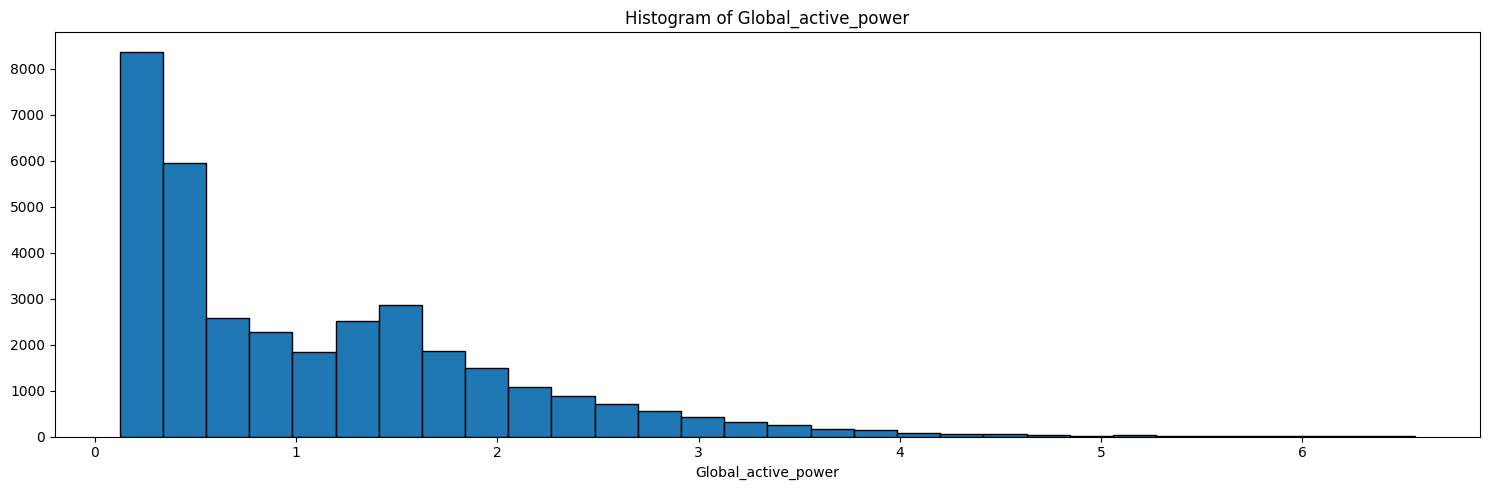

In [17]:
plt.figure(figsize=(15, 5))
plt.hist(hourly_df['Global_active_power'].dropna(), bins=30, edgecolor='black')
plt.title(f'Histogram of {'Global_active_power'}')
plt.xlabel('Global_active_power')
plt.tight_layout()
plt.show()

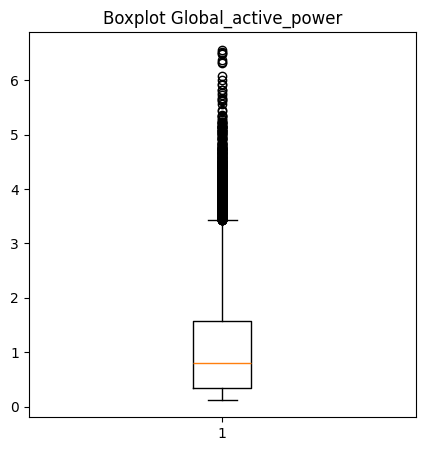

In [18]:
plt.figure(figsize=(5, 5))
plt.boxplot(hourly_df['Global_active_power'])
plt.title('Boxplot Global_active_power')
plt.show()

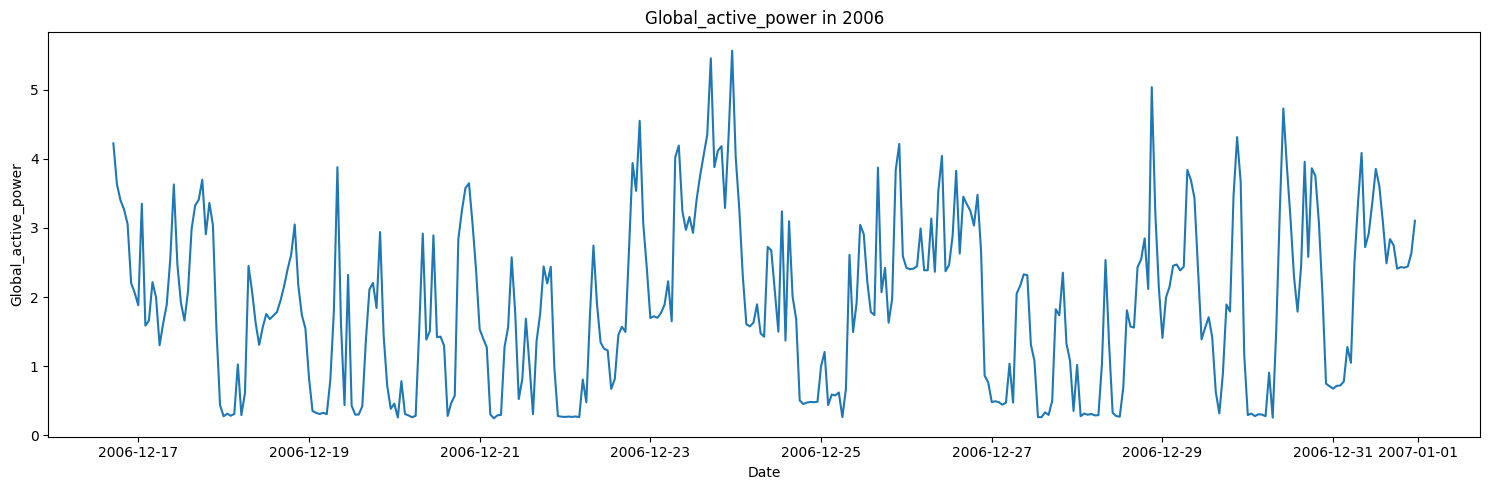

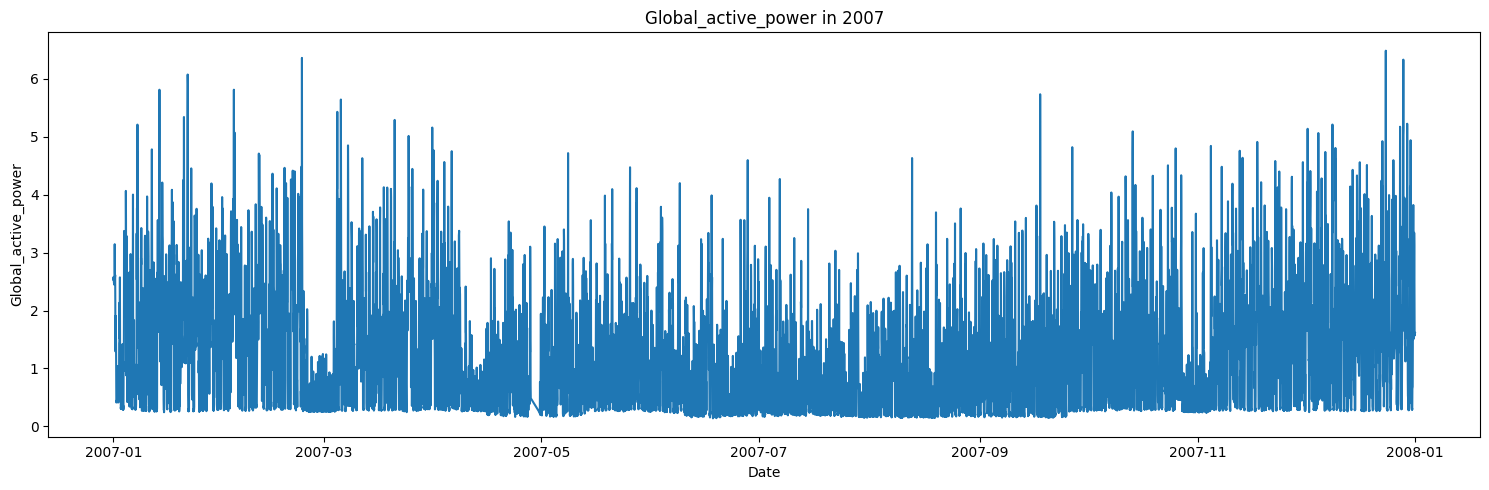

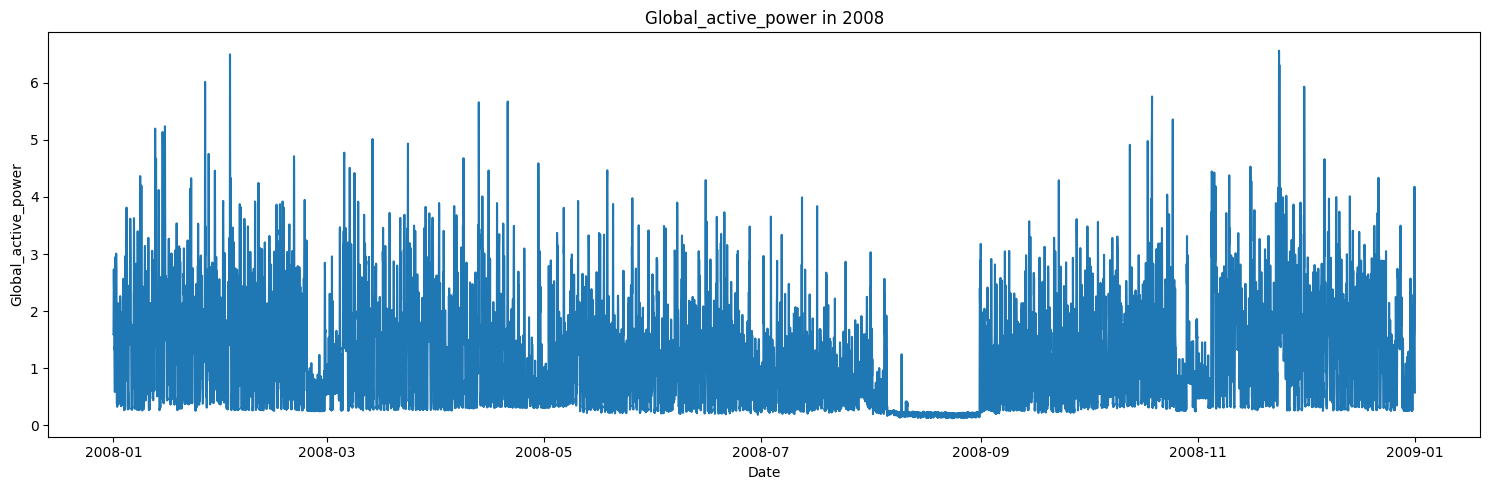

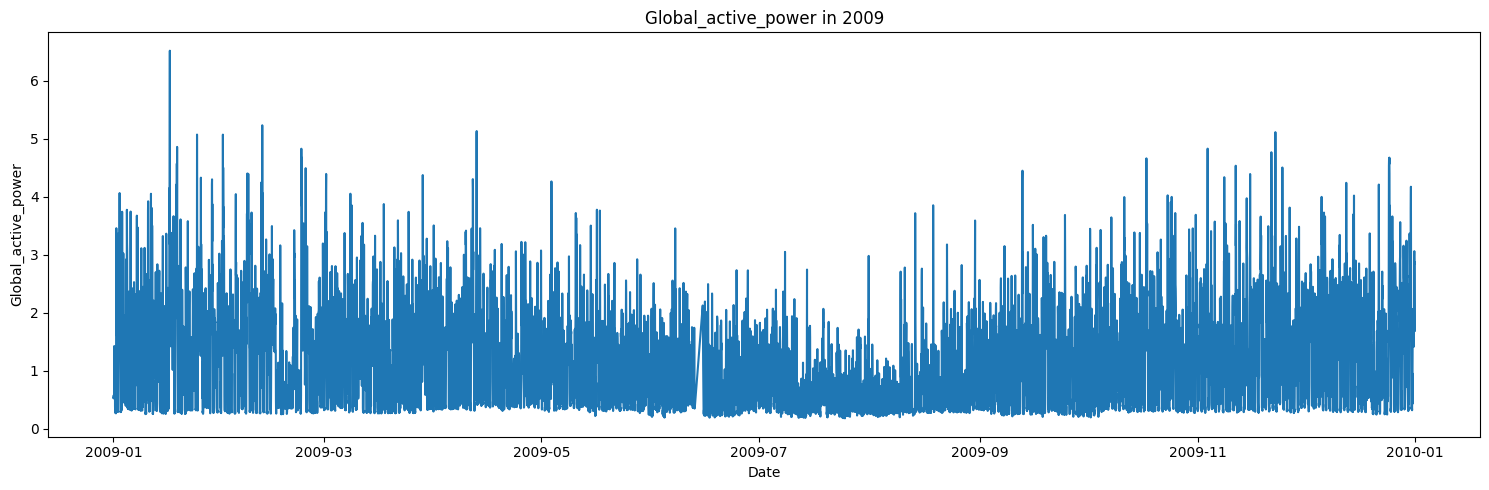

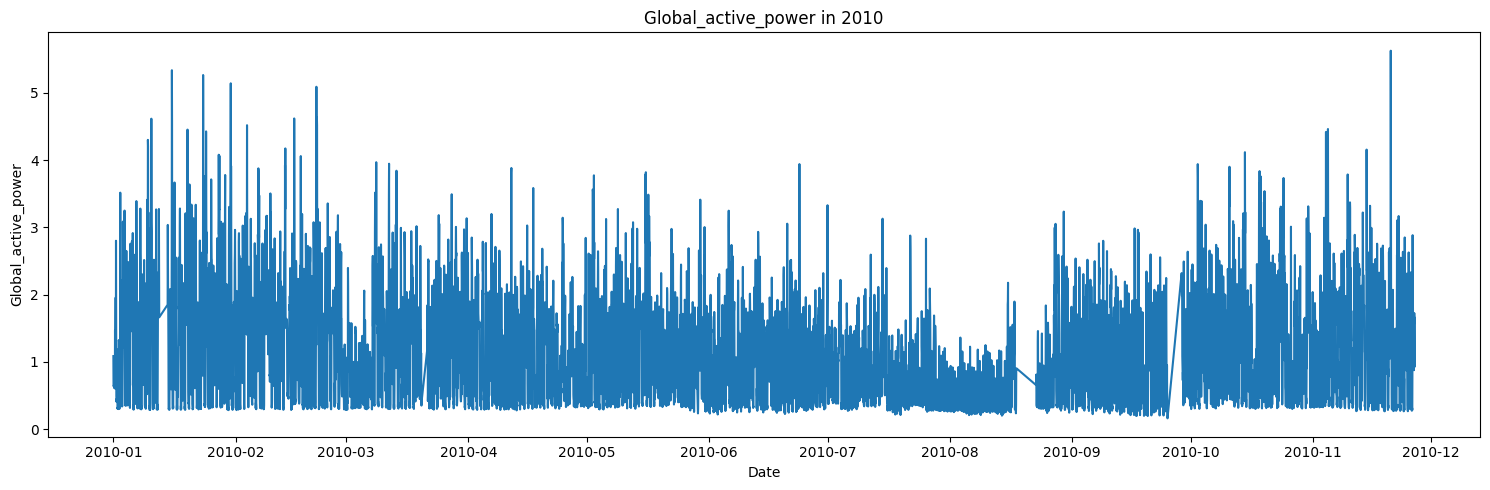

In [19]:
# Extract year from index
hourly_df['Year'] = hourly_df.index.year

# Select numeric columns excluding 'Year'
numeric_cols = hourly_df.select_dtypes(include='number').drop(columns='Year').columns

# Plot for each year

years = hourly_df['Year'].unique()
for year in sorted(years):
    plt.figure(figsize=(15, 5))
    yearly_data = hourly_df[hourly_df['Year'] == year]
    plt.plot(yearly_data.index, yearly_data['Global_active_power'])
    plt.title(f'Global_active_power in {year}')
    plt.xlabel('Date')
    plt.ylabel('Global_active_power')
    plt.tight_layout()
    plt.show()

### Time decomposition

Monthly

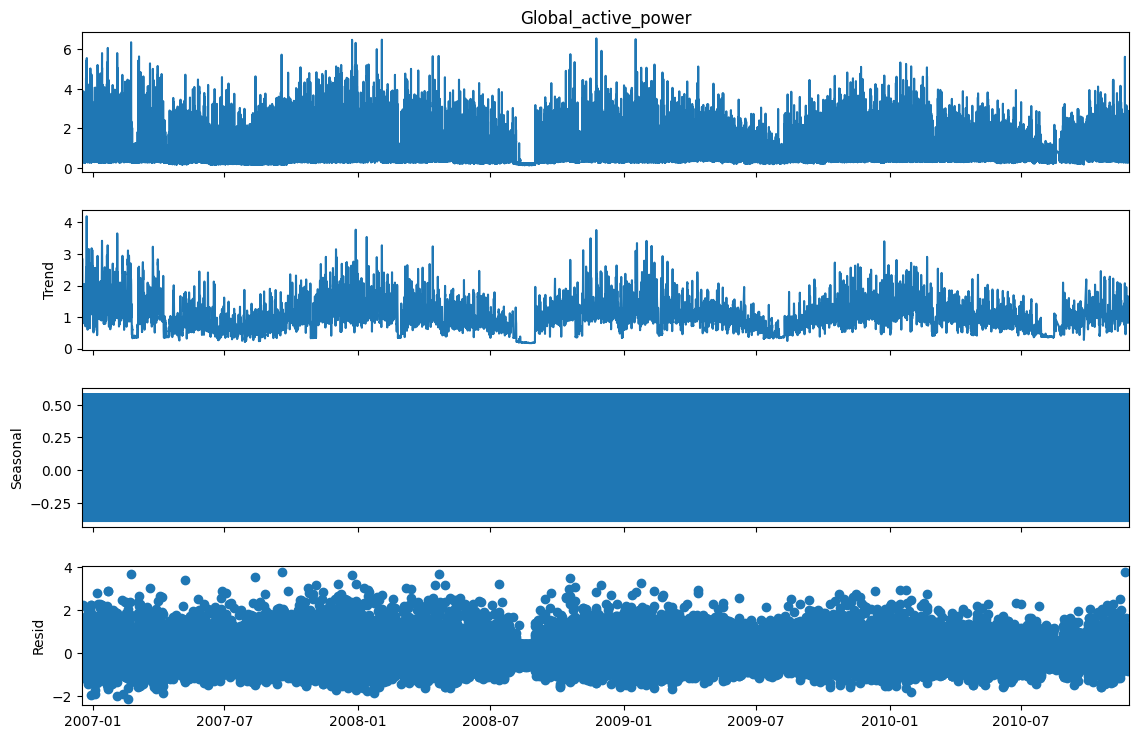

In [20]:
# all dataset

decomposition = seasonal_decompose(hourly_df['Global_active_power'], model='addictive', period=12) # 12 - monthly pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

Daily on some months

In [21]:
# january

daily_df_2007_jan = hourly_df[(hourly_df.index.year == 2007) & (hourly_df.index.month == 1)]


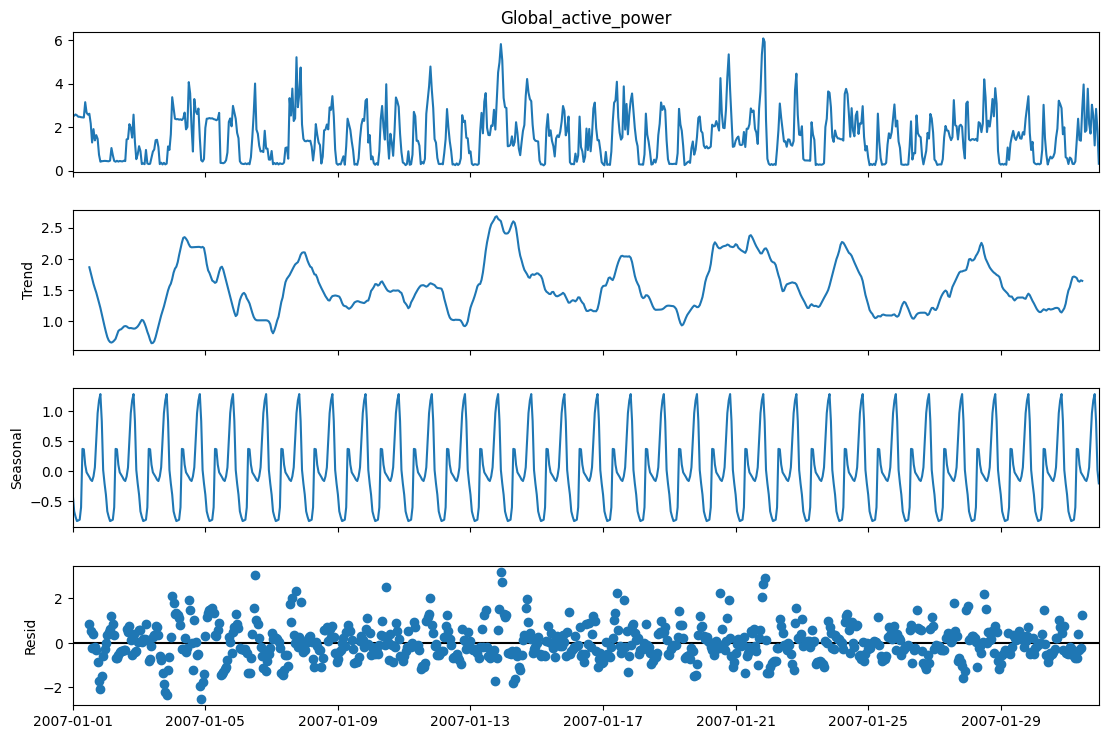

In [22]:
decomposition = seasonal_decompose(daily_df_2007_jan['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

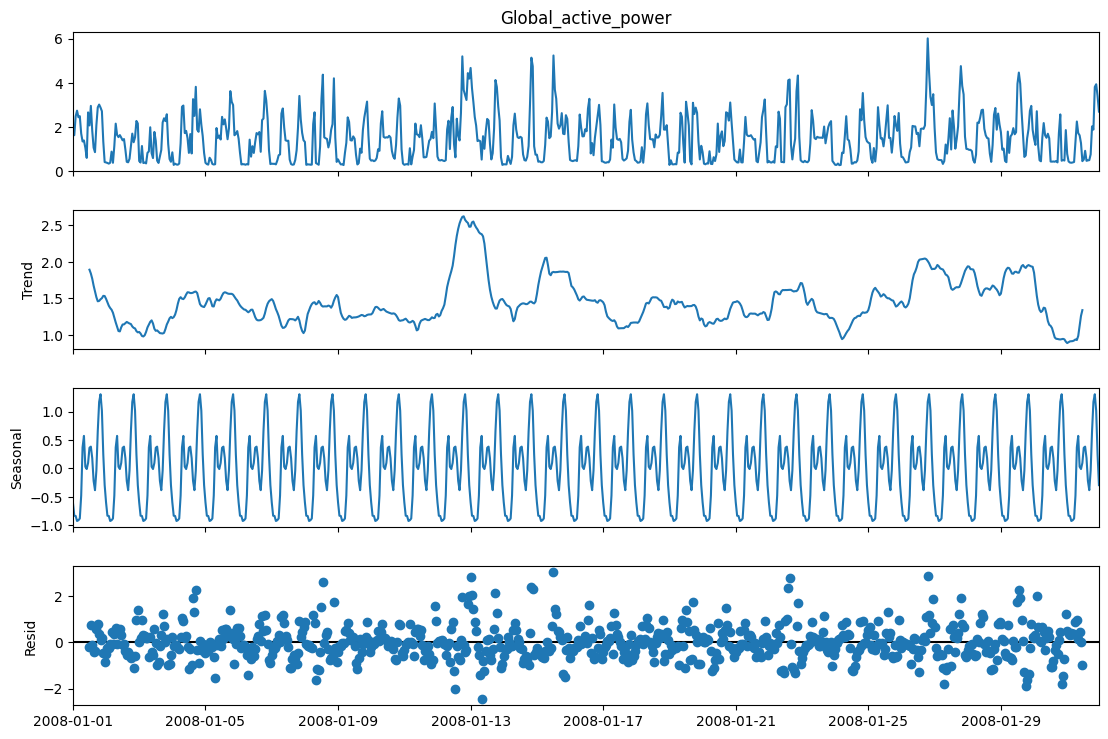

In [23]:
# jan 2008
daily_df_2008_jan = hourly_df[(hourly_df.index.year == 2008) & (hourly_df.index.month == 1)]

decomposition = seasonal_decompose(daily_df_2008_jan['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

In [24]:
# february

daily_df_2007_feb = hourly_df[(hourly_df.index.year == 2007) & (hourly_df.index.month == 2)]

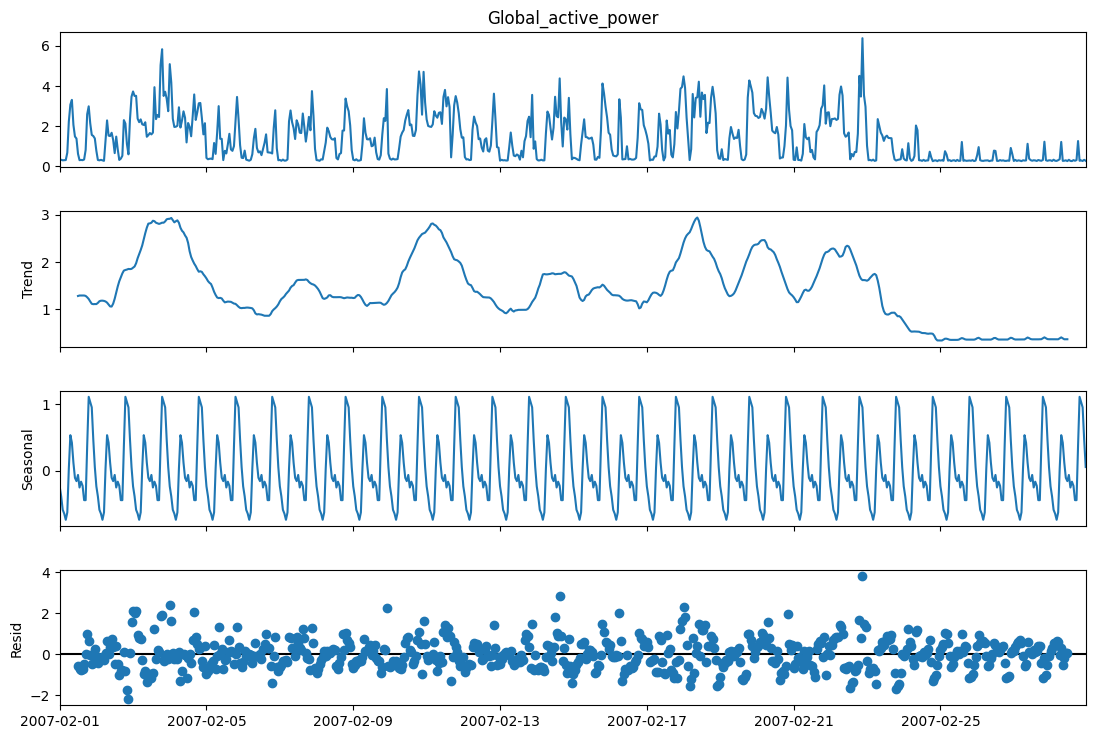

In [25]:
decomposition = seasonal_decompose(daily_df_2007_feb['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

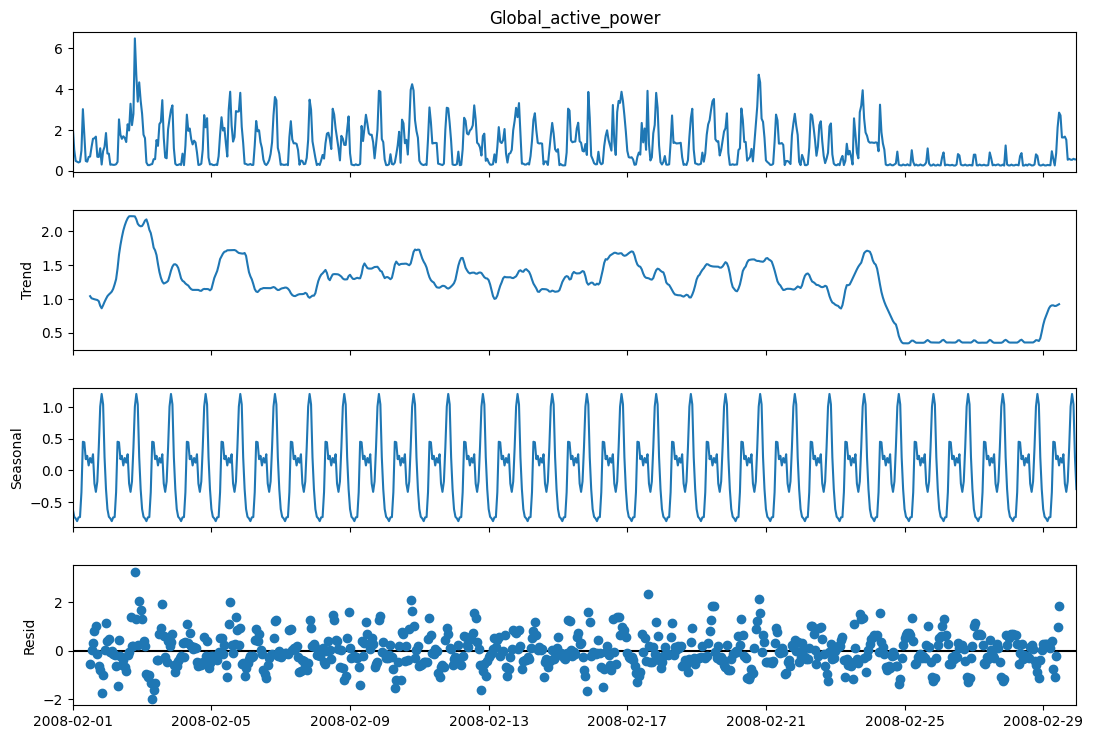

In [26]:
# fev 2008

daily_df_2008_feb = hourly_df[(hourly_df.index.year == 2008) & (hourly_df.index.month == 2)]

decomposition = seasonal_decompose(daily_df_2008_feb['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

In [27]:
# june

daily_df_2007_jun = hourly_df[(hourly_df.index.year == 2007) & (hourly_df.index.month == 7)]

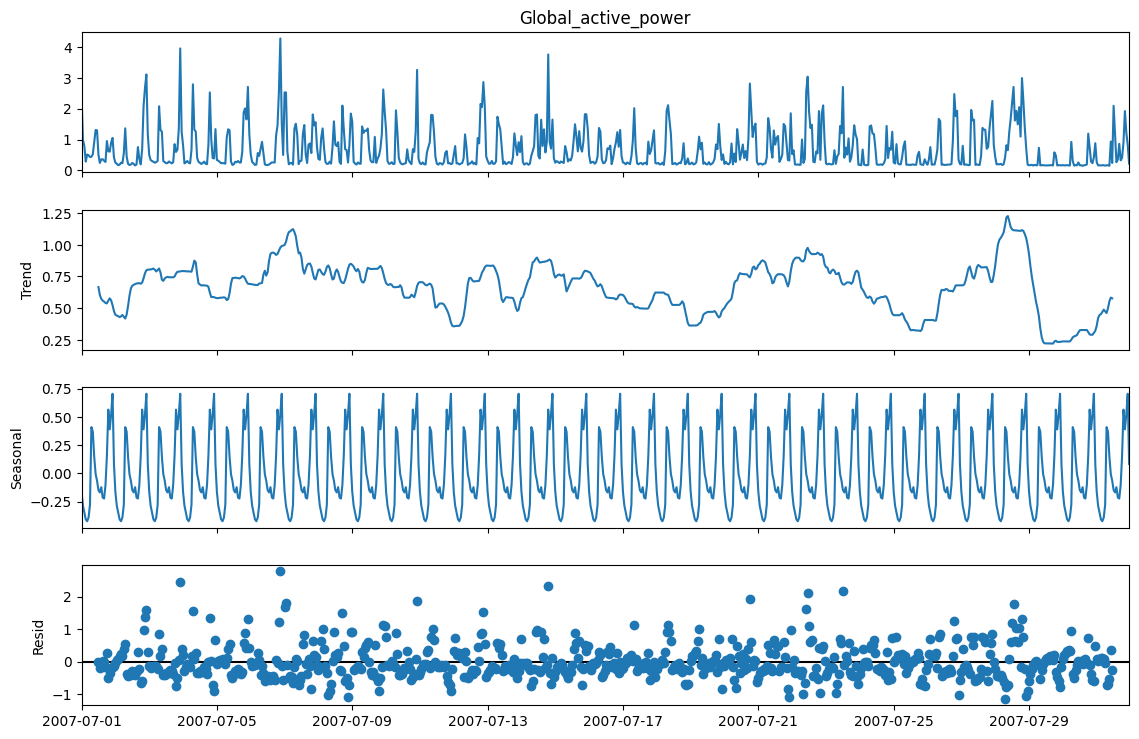

In [28]:
decomposition = seasonal_decompose(daily_df_2007_jun['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

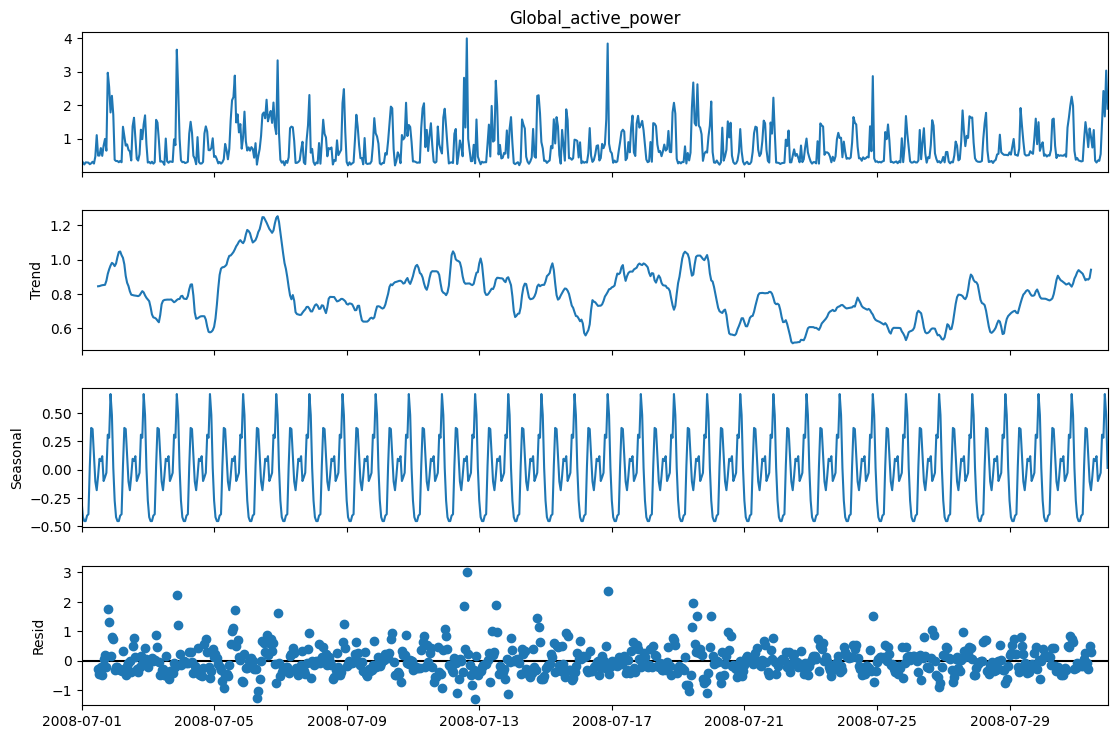

In [29]:
# june 2008

daily_df_2008_jun = hourly_df[(hourly_df.index.year == 2008) & (hourly_df.index.month == 7)]

decomposition = seasonal_decompose(daily_df_2008_jun['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

In [30]:
# december

daily_df_2007_dec = hourly_df[(hourly_df.index.year == 2007) & (hourly_df.index.month == 12)]

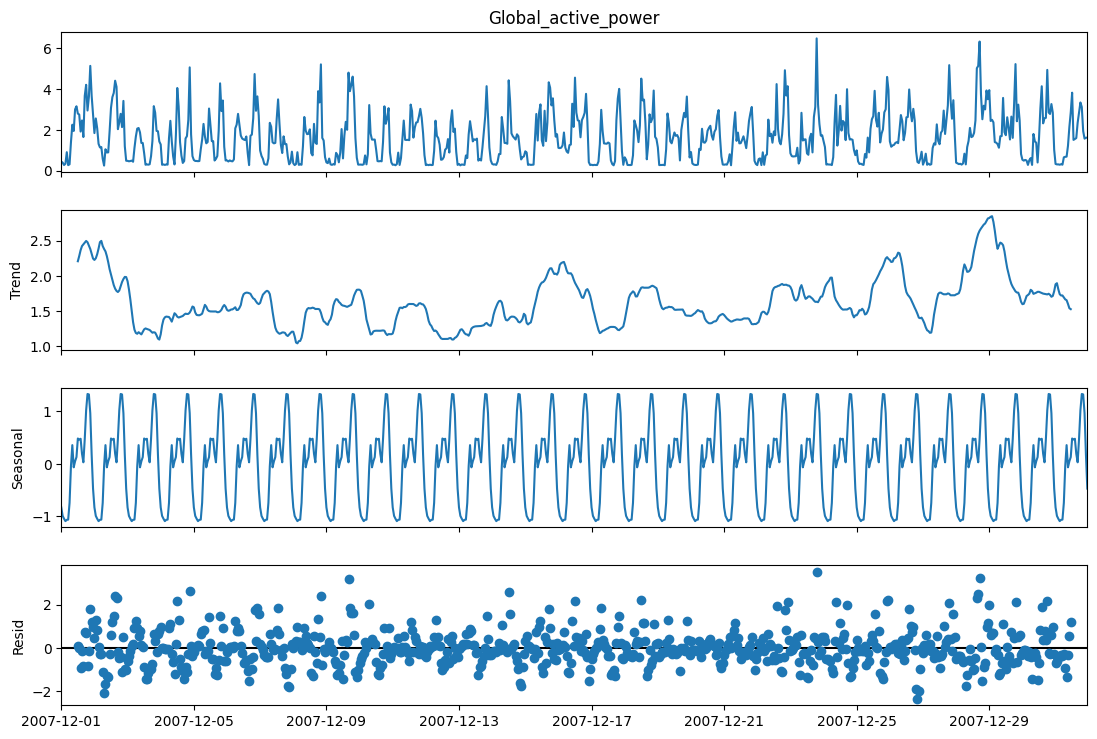

In [31]:
decomposition = seasonal_decompose(daily_df_2007_dec['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

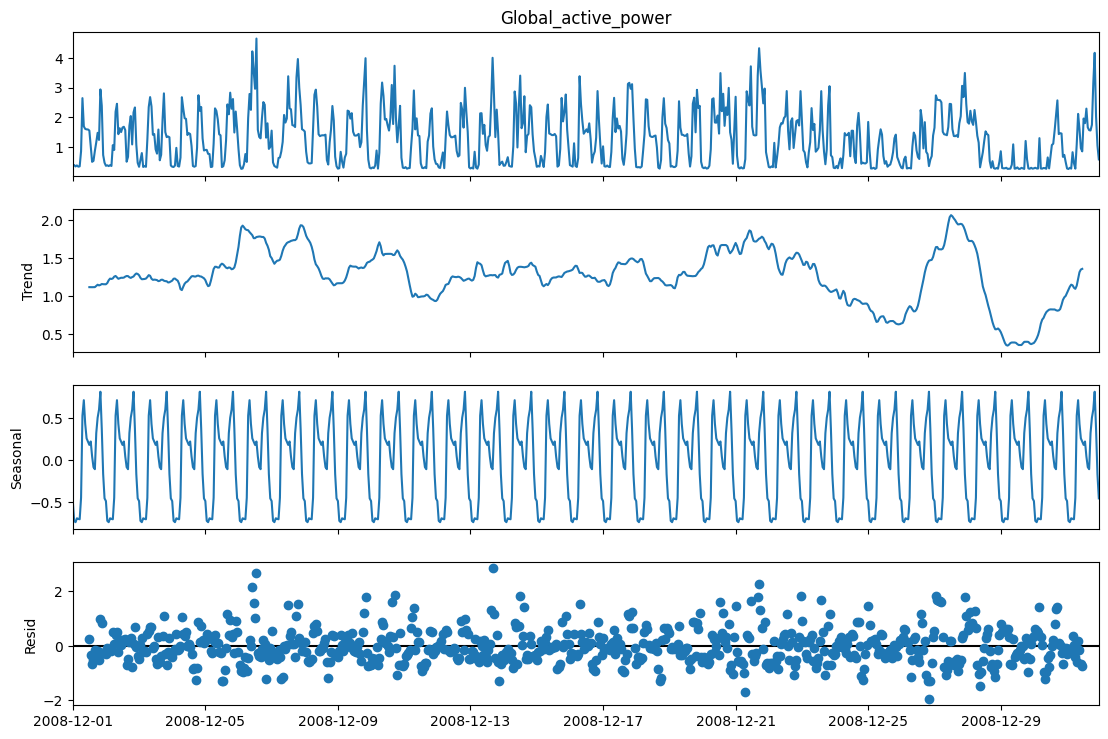

In [32]:
# december 2008

daily_df_2008_dec = hourly_df[(hourly_df.index.year == 2008) & (hourly_df.index.month == 12)]

decomposition = seasonal_decompose(daily_df_2008_dec['Global_active_power'], model='addictive', period=24) # 24 - daily pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

Analyzing the trend we can see that in colder months near January we have higher consumption, and in warmer months we have lower consumption. As well as, 2 main peaks one in the morning and one by the end of the day.

To reduce noise in the measurements we will average Global active power, with in the months of the different years

In [33]:
daily_df_2007_2010 = hourly_df[(hourly_df.index.year >= 2007)]

In [34]:
# Create a composite key: month-day-hour
hourly_df['month_day_hour'] = hourly_df.index.strftime('%m-%d-%H')

# Group by that key and avg
avg_by_month_day_hour = hourly_df.groupby('month_day_hour')['Global_active_power'].mean()

In [35]:
avg_by_month_day_hour.index = pd.to_datetime('2000-' + avg_by_month_day_hour.index, format='%Y-%m-%d-%H')

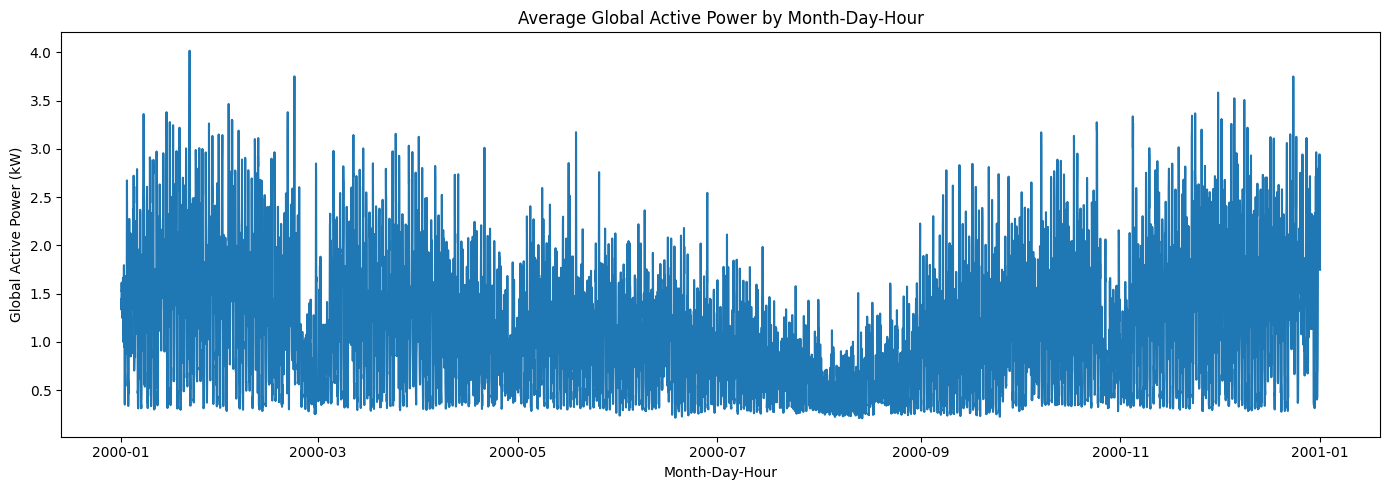

In [36]:
plt.figure(figsize=(14, 5))
plt.plot(avg_by_month_day_hour.index, avg_by_month_day_hour.values)
plt.title('Average Global Active Power by Month-Day-Hour')
plt.xlabel('Month-Day-Hour')
plt.ylabel('Global Active Power (kW)')
#plt.xticks(rotation=90)  # Optional: rotate x-axis labels for readability
plt.tight_layout()
plt.show()

Warm weather - abr-set

In [37]:
avg_warm = avg_by_month_day_hour[(avg_by_month_day_hour.index.month >= 4) & (avg_by_month_day_hour.index.month <= 9)]

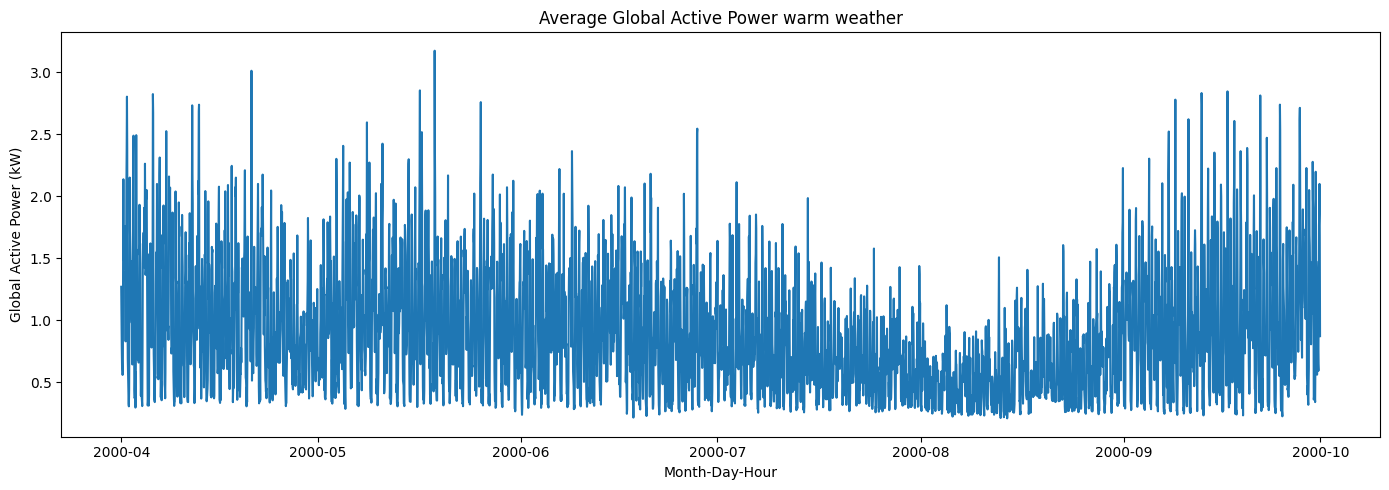

In [38]:
plt.figure(figsize=(14, 5))
plt.plot(avg_warm.index, avg_warm.values)
plt.title('Average Global Active Power warm weather')
plt.xlabel('Month-Day-Hour')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

In [39]:
avg_warm_df = avg_warm.to_frame(name='Global_active_power') #convert to df

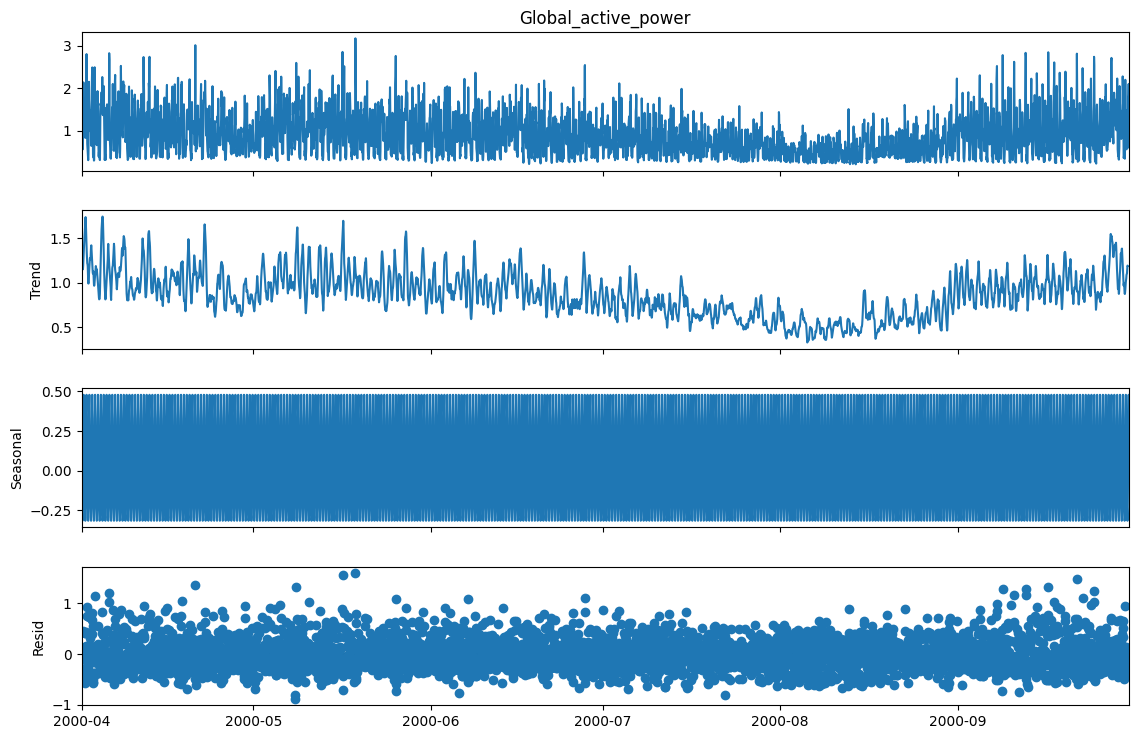

In [40]:
decomposition = seasonal_decompose(avg_warm_df['Global_active_power'], model='addictive', period=12) # monthly pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

Cold weather - out-mar

In [41]:
avg_cold_1 = avg_by_month_day_hour[(avg_by_month_day_hour.index.month >= 10) & (avg_by_month_day_hour.index.month <= 12)]

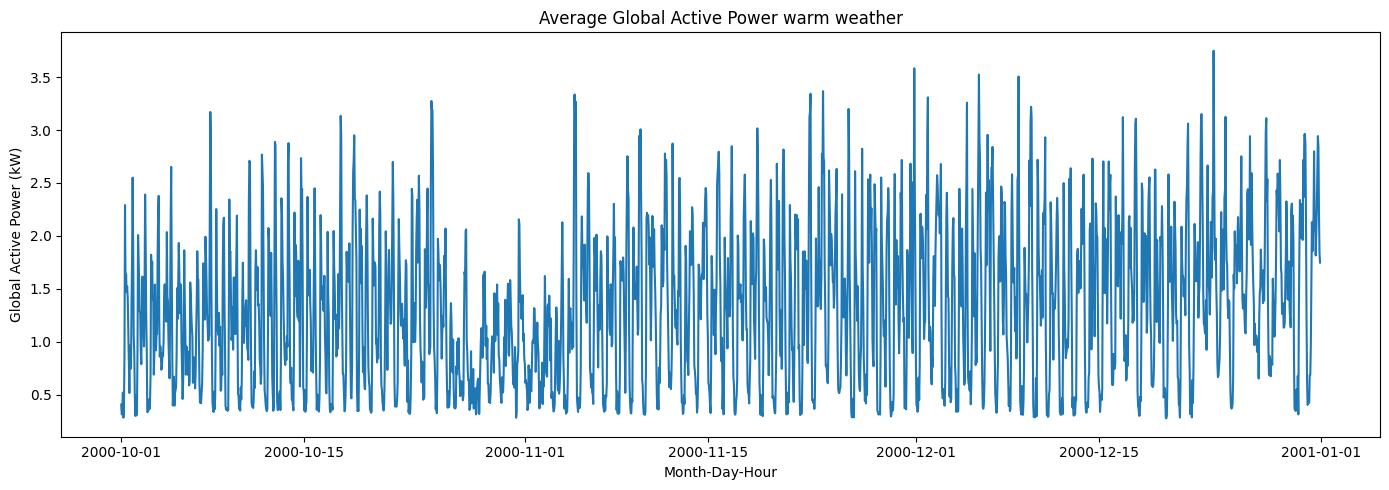

In [42]:
plt.figure(figsize=(14, 5))
plt.plot(avg_cold_1.index, avg_cold_1.values)
plt.title('Average Global Active Power warm weather')
plt.xlabel('Month-Day-Hour')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

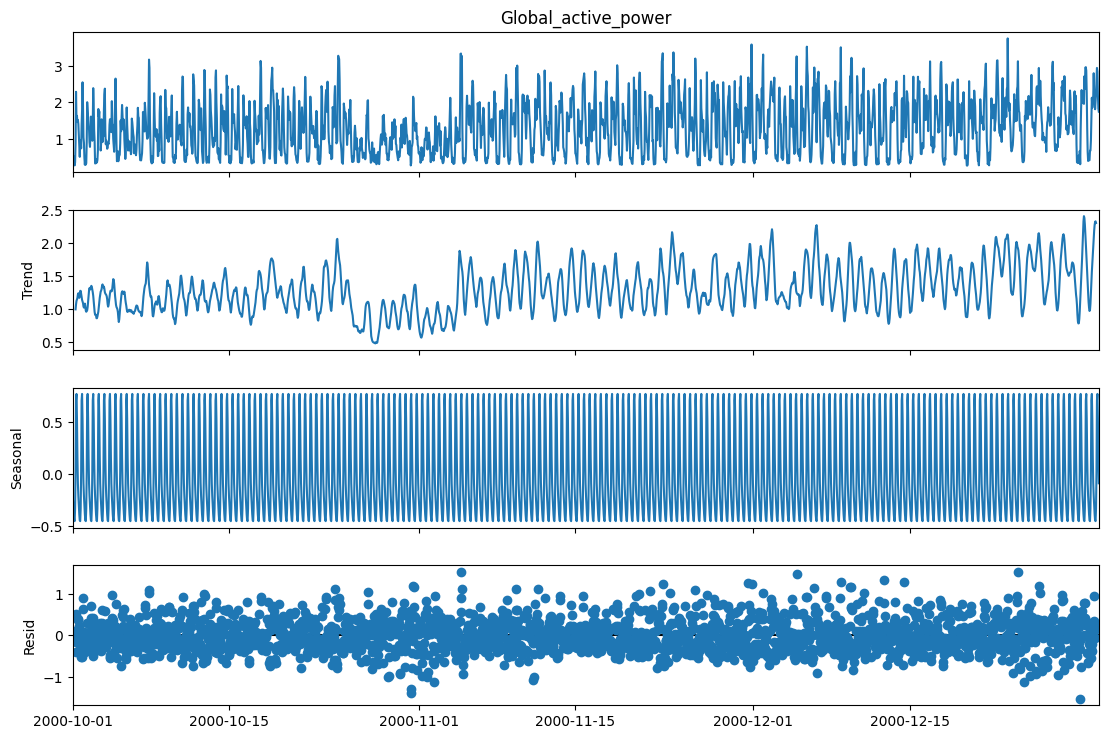

In [43]:
avg_cold_1_df = avg_cold_1.to_frame(name='Global_active_power') #convert to df

decomposition = seasonal_decompose(avg_cold_1_df['Global_active_power'], model='addictive', period=12) # monthly pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

In [44]:
avg_cold_2 = avg_by_month_day_hour[(avg_by_month_day_hour.index.month >= 1) & (avg_by_month_day_hour.index.month <= 3)]

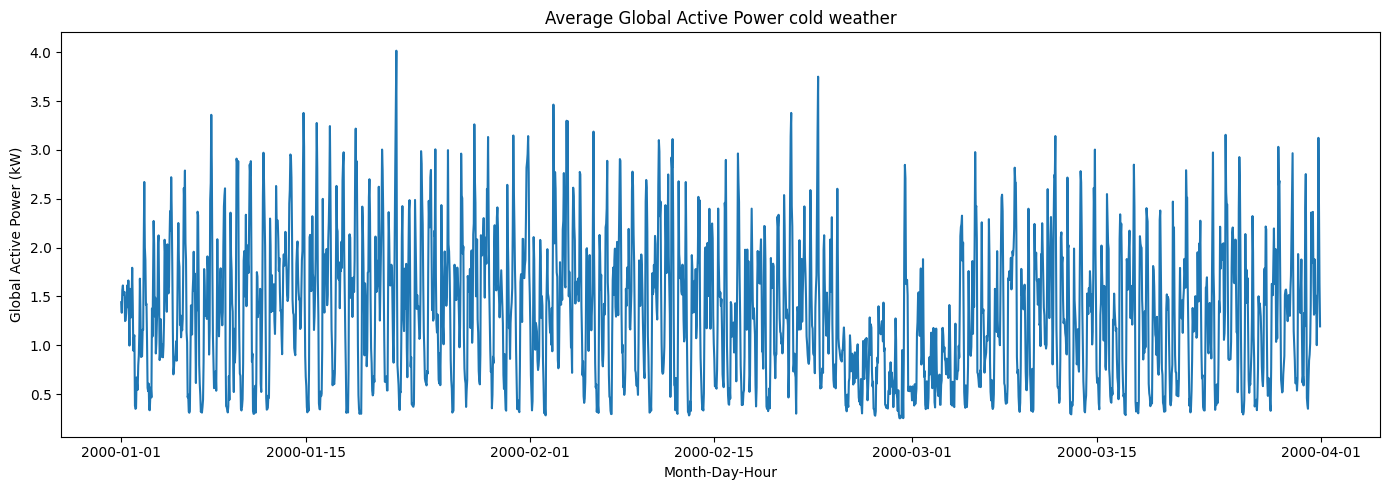

In [45]:
plt.figure(figsize=(14, 5))
plt.plot(avg_cold_2.index, avg_cold_2.values)
plt.title('Average Global Active Power cold weather')
plt.xlabel('Month-Day-Hour')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

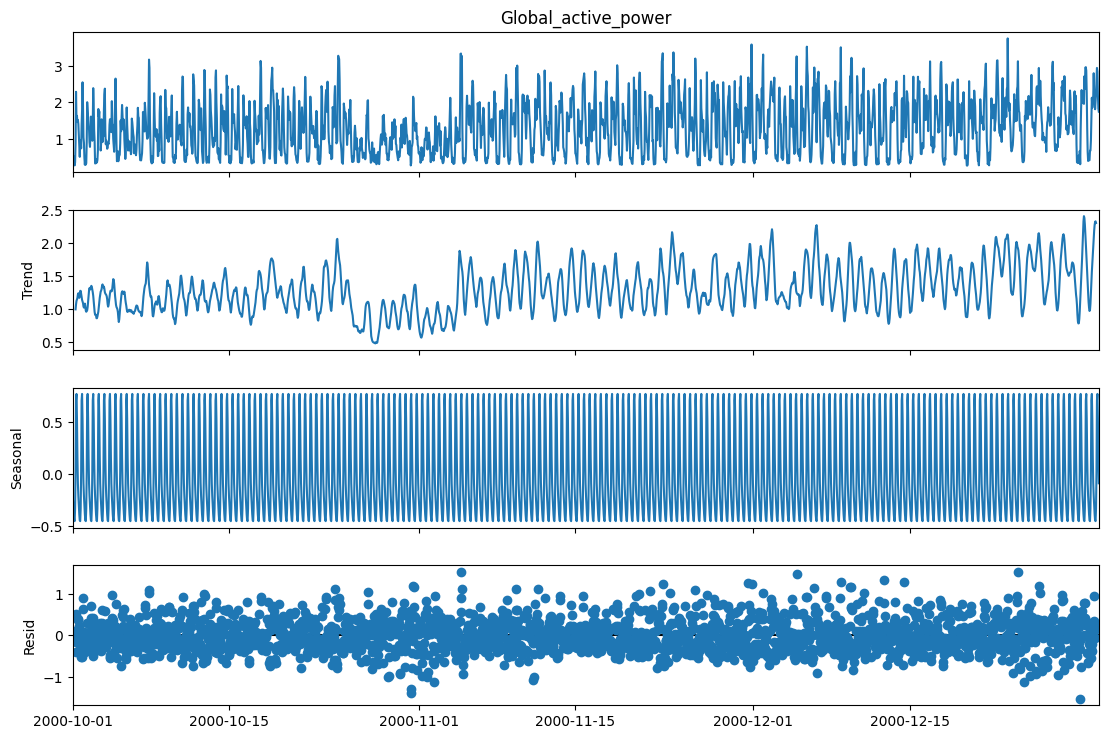

In [46]:
avg_cold_1_df = avg_cold_1.to_frame(name='Global_active_power') #convert to df

decomposition = seasonal_decompose(avg_cold_1_df['Global_active_power'], model='addictive', period=12) # monthly pattern

#plot

fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

### Check for stationary

In [47]:
hourly_df.drop(columns=['Year', 'month_day_hour'], inplace=True)

In [48]:
result = adfuller(hourly_df['Global_active_power'])

print('ADF statistic:', result[0])
print('p-value:', result[1])

for key, value in result[4].items():
    print(f'critical value ({key}): {value:.3f}')

ADF statistic: -14.3713446892215
p-value: 9.482687472632919e-27
critical value (1%): -3.431
critical value (5%): -2.862
critical value (10%): -2.567


Despite the result of the ADF that indicates that stationary, the plots expose some trends and seasonality

C:\Users\dcavalei\AppData\Local\Temp\ipykernel_22280\1750088668.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_weekly = hourly_df['Global_active_power'].resample('M').mean()


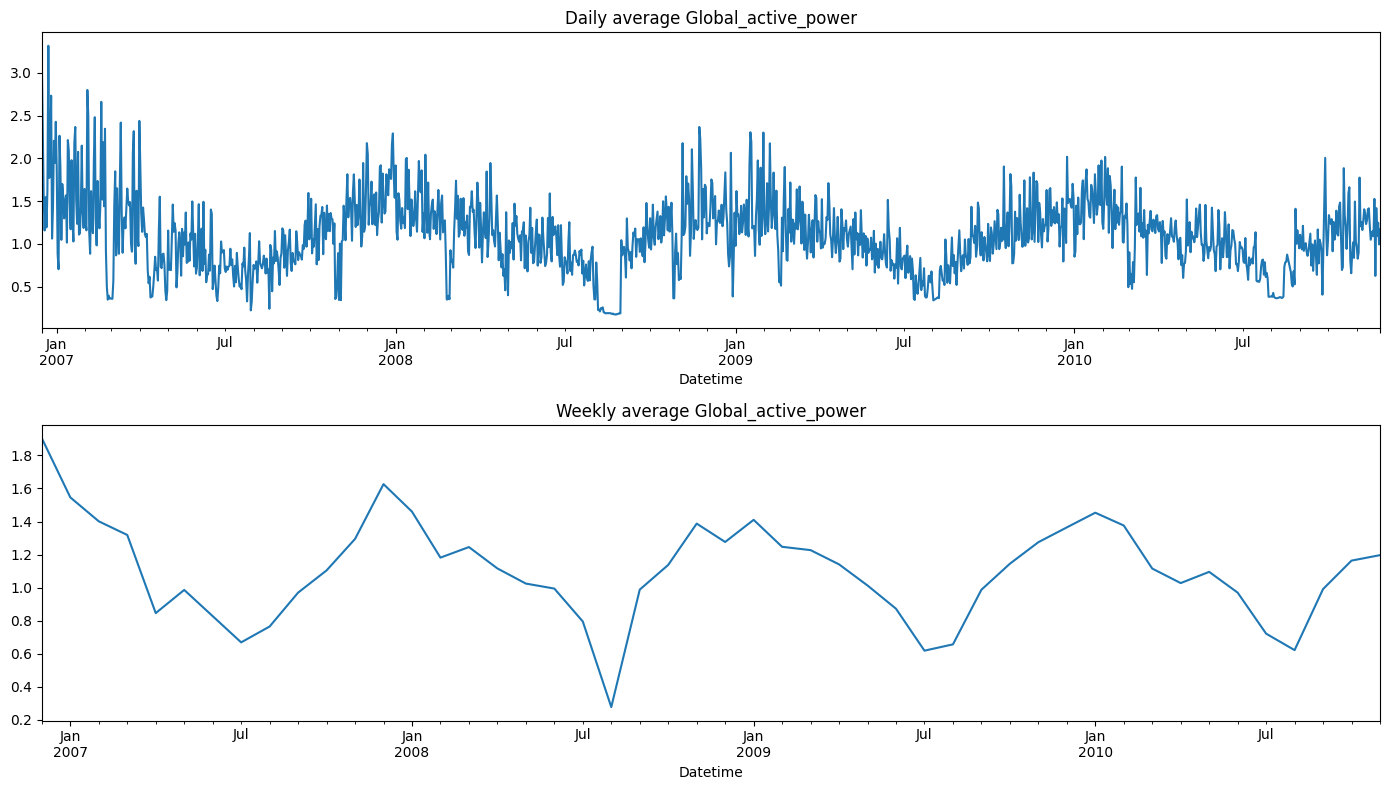

In [49]:
df_daily = hourly_df['Global_active_power'].resample('D').mean()
df_weekly = hourly_df['Global_active_power'].resample('M').mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
df_daily.plot(ax=axes[0], title='Daily average Global_active_power')
df_weekly.plot(ax=axes[1], title='Weekly average Global_active_power')
plt.tight_layout()
plt.show()

Lets use the df with the mean values, with reduced noise

In [50]:
avg_by_month_day_hour_df = avg_by_month_day_hour.to_frame(name='Global_active_power') #convert to df

In [51]:
avg_by_month_day_hour_df

Global_active_power
month_day_hour                          
2000-01-01 00:00:00             1.442092
2000-01-01 01:00:00             1.333667
2000-01-01 02:00:00             1.566508
2000-01-01 03:00:00             1.613075
2000-01-01 04:00:00             1.518708
...                                  ...
2000-12-31 19:00:00             2.942633
2000-12-31 20:00:00             2.846208
2000-12-31 21:00:00             2.228158
2000-12-31 22:00:00             1.832583
2000-12-31 23:00:00             1.746775

[8784 rows x 1 columns]

In [52]:
# check stationary in the less noisy df

result = adfuller(avg_by_month_day_hour_df['Global_active_power'])

print('ADF statistic:', result[0])
print('p-value:', result[1])

for key, value in result[4].items():
    print(f'critical value ({key}): {value:.3f}')

ADF statistic: -5.566142116531426
p-value: 1.5032429243991966e-06
critical value (1%): -3.431
critical value (5%): -2.862
critical value (10%): -2.567


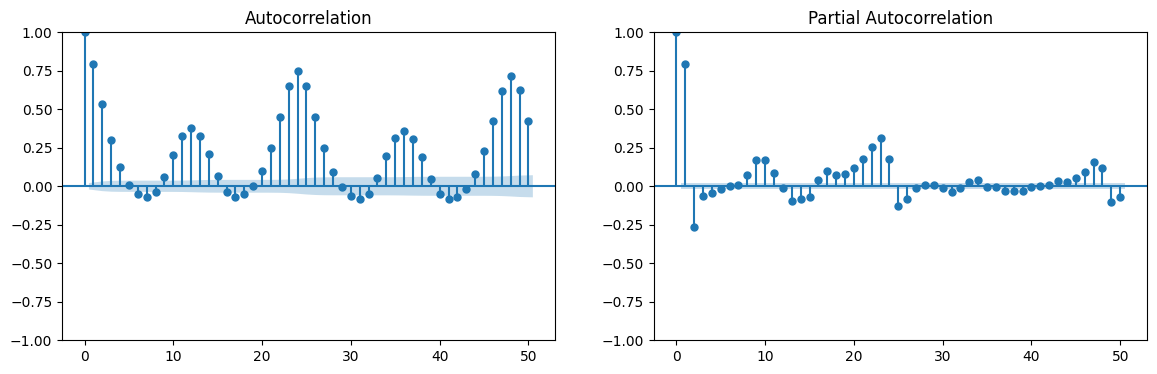

In [53]:
# visualize autocorrelation(ACF) and partial autocorrelation (PACF)

fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(avg_by_month_day_hour_df, lags=50, ax=axes[0])
plot_pacf(avg_by_month_day_hour_df, lags=50, ax=axes[1])
plt.show()

**Autocorrelation plot**
- Show a strong daily seasonality.
- Each 'wave' correspond to one day's repetition of energy usage pattern

**Partial autocorrelation plot**
- The big spike, and then the smaller bumps suggest both short-term correlation (recent hours affect current usage) and seasonal effects repeating daily.


**To make this stationary, we'll need seasonal differencing, not just simple differencing.**

In [54]:
# apply seasonal differencing

df_seasonal_diff = avg_by_month_day_hour_df.diff(24).dropna()

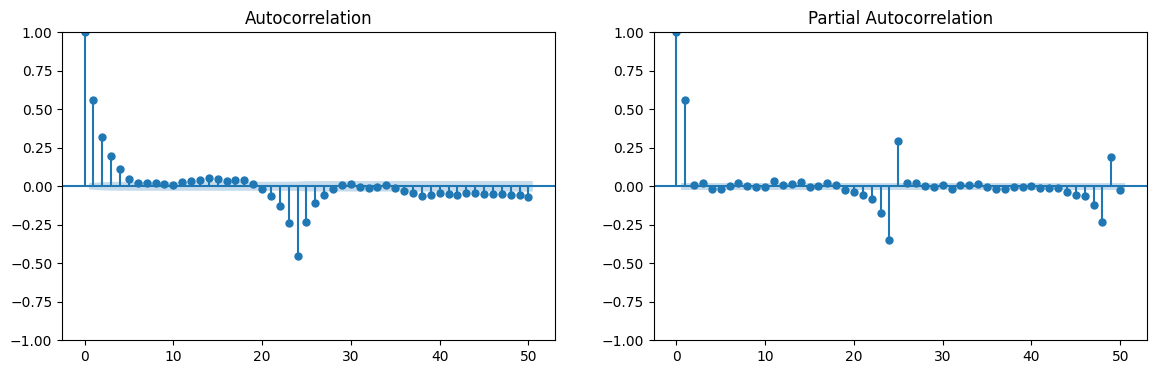

In [55]:
# plotting autocorrelation(ACF) and partial autocorrelation (PACF) again

fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(df_seasonal_diff, lags=50, ax=axes[0])
plot_pacf(df_seasonal_diff, lags=50, ax=axes[1])
plt.show()

**Autocorrelation plot**
- We have a smoothly decay toward to 0.
- No large, repeating 24h spikes, meaning the daily seasonlity has been removed successfully.
- Now we're left with short-term autocorrelation that can be modeled by standard ARMA structure.

**Partial autocorrelation plot**
- Big spike at lag 1 - strong autoregressive effect (AR = 1)
- The series likely needs a small autoregressive term  (p = 1 or 2) and possibly a small moving-average term (q = 1), since ACF also decays gradually

- Was performed 1 seasonal differencing (D = 1)
- Seasonality (daily) (s = 24)
- Trend differencing (d = 0) we only removed seasonality

### SARIMA model
The data has:
- **AR structure** (PACF lag 1 spike)
- **MA structure** (ACF gradual decay)
- **Seasonality** (period = 24)

In [56]:
# SARIMA (p,d,q) (P,D,Q,s)
# (p,d,q) - non seasonal - (1, 0, 1)
# (P,D,Q,s) - seasonal - (1, 1, 1, 24)

In [57]:
model = SARIMAX(avg_by_month_day_hour_df['Global_active_power'],
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results_SARIMAX = model.fit()
print(results_SARIMAX.summary())

c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                 8784
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -1635.926
Date:                            Fri, 17 Oct 2025   AIC                           3281.852
Time:                                    14:28:39   BIC                           3317.226
Sample:                                01-01-2000   HQIC                          3293.907
                                     - 12-31-2000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6038      0.012     49.668      0.000       0.580       0.628
ma.L1          0.0135      0.015   

**Output interpretation**

1. Coefficients
- **ar.L1** - Strong positive autocorrelation at lag 1. Significant.
- **ma.L1** - Not significant. MA may not be contributing much.
- **ar.S.L24** - Seasonal AR(1) at lag 24 (daily). Small but significant.
- **ma.S.L24** - Significant and strong seasonal MA effect at lag 24. The large magnitude of (−1.05) suggests a strong seasonal moving average component—possibly absorbing daily fluctuations.

2. Residuals
- **Ljung-Box (L1)** - Prob = 0.99 → No autocorrelation at lag 1.
- **Jarque-Bera (JB)** - Prob = 0.00 → Residuals are not normally distributed.
- **Heteroskedasticity** - Prob = 0.35 → Evidence of non-constant variance.
- **Skew** - Right-skewed residuals.
- **Kurtosis** - Heavy tails.

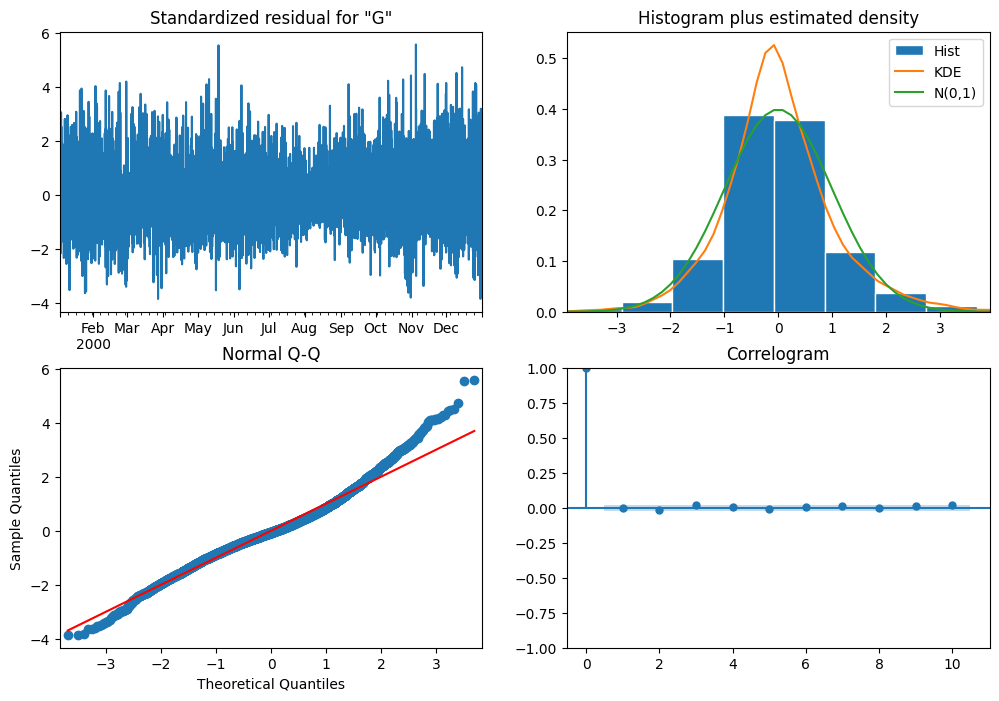

In [58]:
# plot diagnostics

results_SARIMAX.plot_diagnostics(figsize=(12,8))
plt.show()

**Diagnostics plots comment**

**Standardized Residuals (Top-Left Plot)**

This plot shows how residuals behave over time.
- Residuals randomly scattered around zero.


**Histogram + Density (Top-Right Plot)**

This checks if residuals are approximately normally distributed.
- Histogram should be resembling a bell curve, KDE (orange) close to the normal curve (green). In our plot the KDE and normal curve are close but could be better.


**Normal Q-Q Plot (Bottom-Left)**

This compares residual quantiles to a theoretical normal distribution.
- Points should be around the red diagonal line. Most points lie close to the line, residuals are approximately normal.


**Correlogram (Bottom-Right)**

This tests for autocorrelation in residuals.
- Most bars are within bounds, the SARIMA model has likely captured the temporal structure well.

In [59]:
avg_by_month_day_hour_df['Global_active_power_log'] = np.log(avg_by_month_day_hour_df['Global_active_power'])

In [60]:
# different combination of SARIMAX and log of 'Global_active_power' values

model = SARIMAX(avg_by_month_day_hour_df['Global_active_power_log'],
                order=(1, 0, 0),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results_SARIMAX = model.fit()
print(results_SARIMAX.summary())

c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:              Global_active_power_log   No. Observations:                 8784
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood               -1204.392
Date:                              Fri, 17 Oct 2025   AIC                           2416.784
Time:                                      08:56:42   BIC                           2445.085
Sample:                                  01-01-2000   HQIC                          2426.428
                                       - 12-31-2000                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6263      0.008     82.095      0.000       0.611       0.641
ar.S.L24       0.04

1. Residuals
- **Before log:** Highly skewed with heavy tails.
- **After log:** Skewness drops to -0.15, and kurtosis to 3.56—much closer to normality.
- The log transformation successfully normalized the distribution, which improves model assumptions and residual behavior.

2. Stationarity (ADF Test)
- Both versions are stationary, but the log-transformed series likely has more stable variance, which is crucial for SARIMA.

3. Model comparison
- AIC/BIC: Lower values → better model fit.
- Residuals: Much closer to normality and still has heteroskedasticity.
- Model simplicity: Dropping MA from the non-seasonal part it improved performance.

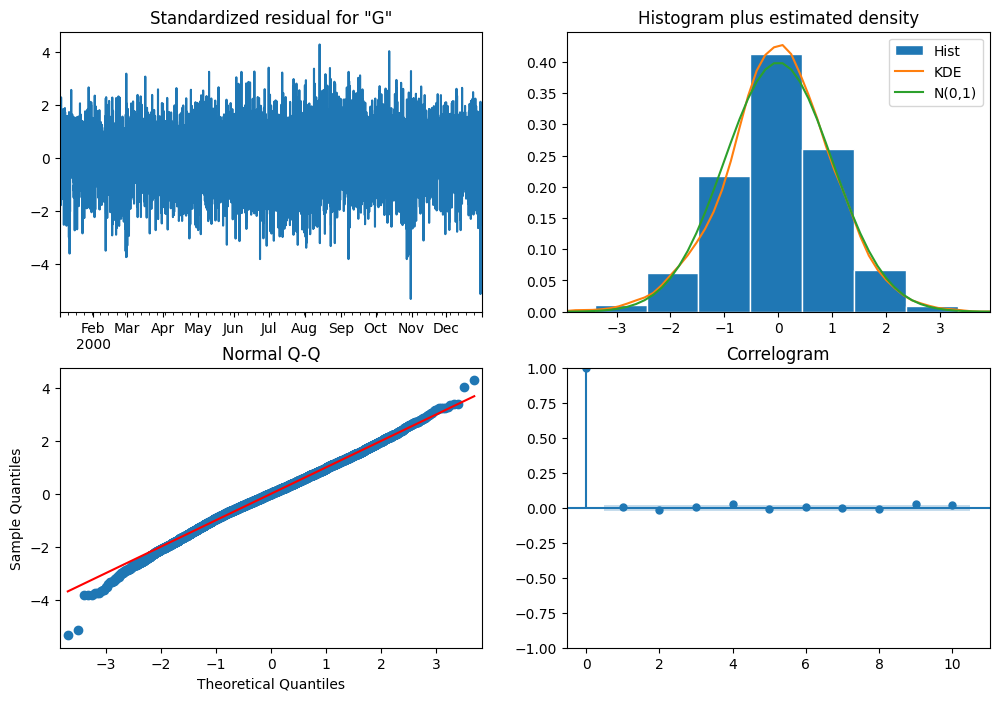

In [61]:
results_SARIMAX.plot_diagnostics(figsize=(12,8))
plt.show()

Overall better diagnostics representations

### Rolling forecast
Forecast 1h ahead, then move the window forward. Repeat.

In [62]:
y= avg_by_month_day_hour_df['Global_active_power_log']

In [ ]:
train_size = int(len(y) * 0.9)

train = y.iloc[:train_size]
test = y.iloc[train_size:]

print(f'Train: {train.index[0]} - {train.index[-1]}')
print(f'Test: {test.index[0]} - {test.index[-1]}')

Train: 2000-01-01 00:00:00 - 2000-11-25 08:00:00
Test: 2000-11-25 09:00:00 - 2000-12-31 23:00:00


In [137]:
h = 1  # forecast 1 step ahead
rolling_forecast = []

for start in range(0, 24 - h, h):
    # Use all real data up to this point
    train_roll = pd.concat([train, test.iloc[:start]])
    
    model = SARIMAX(train_roll,
                    order=(1, 0, 0),
                    seasonal_order=(1, 1, 1, 24),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
    
    forecast = model.forecast(steps=h)
    rolling_forecast.append(forecast)

# Combine all forecasts into a single series
rolling_forecast = pd.concat(rolling_forecast)
rolling_forecast = rolling_forecast[:24]

c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency 

In [139]:
rolling_forecast

2000-11-25 09:00:00    0.341405
2000-11-25 10:00:00    0.361088
2000-11-25 11:00:00    0.283768
2000-11-25 12:00:00    0.319337
2000-11-25 13:00:00    0.357739
2000-11-25 14:00:00    0.220085
2000-11-25 15:00:00    0.008239
2000-11-25 16:00:00   -0.229698
2000-11-25 17:00:00    0.275329
2000-11-25 18:00:00    0.655204
2000-11-25 19:00:00    0.844785
2000-11-25 20:00:00    1.110326
2000-11-25 21:00:00    0.878236
2000-11-25 22:00:00    0.249425
2000-11-25 23:00:00   -0.258877
2000-11-26 00:00:00   -0.558202
2000-11-26 01:00:00   -1.116981
2000-11-26 02:00:00   -1.079621
2000-11-26 03:00:00   -1.129404
2000-11-26 04:00:00   -1.055986
2000-11-26 05:00:00   -0.700026
2000-11-26 06:00:00   -0.468591
2000-11-26 07:00:00    0.868839
Freq: h, dtype: float64

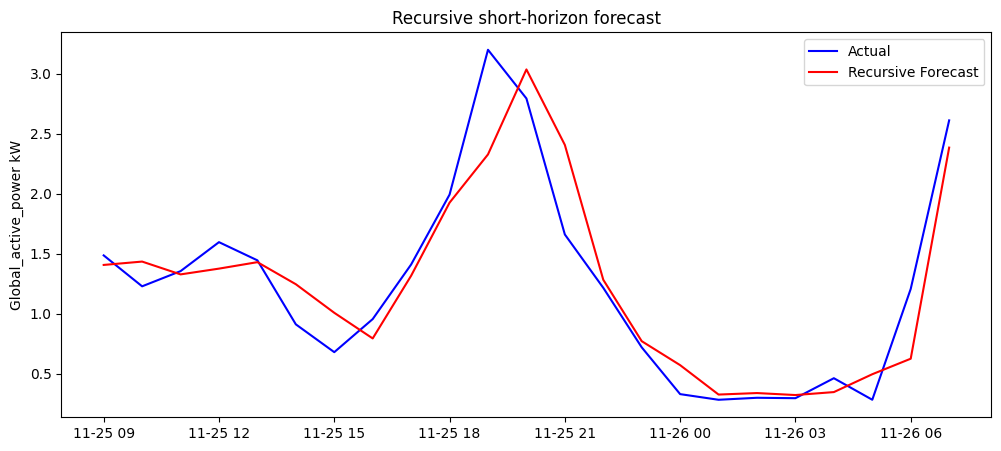

In [141]:
# visualization

plt.figure(figsize=(12,5))
plt.plot(test[:23].index, np.exp(test[:23]), label='Actual', color='blue')
plt.plot(test[:23].index, np.exp(rolling_forecast), label='Recursive Forecast', color='red')
plt.legend()
plt.ylabel('Global_active_power kW')
plt.title('Recursive short-horizon forecast')
plt.show()

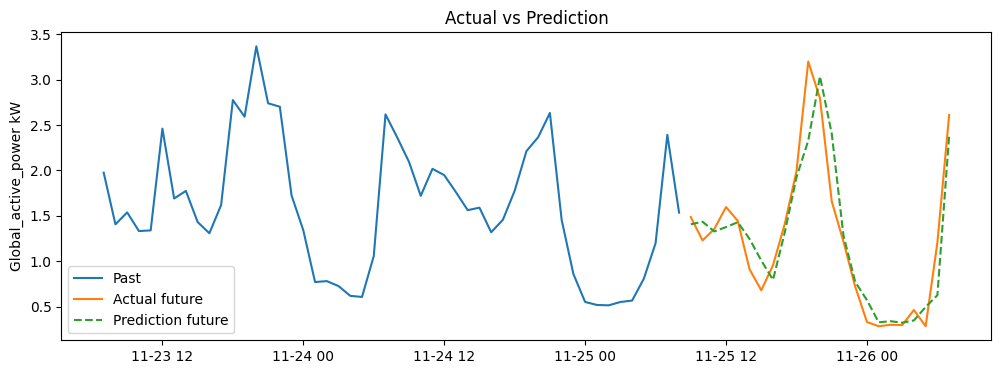

In [142]:
#plot actual vs pred

plt.figure(figsize=(12,4))
plt.plot(np.exp(train[-50:]), label='Past')
plt.plot(np.exp(test[:23]), label='Actual future')
plt.plot(np.exp(rolling_forecast), label='Prediction future', linestyle='--')
plt.ylabel('Global_active_power kW')
plt.title('Actual vs Prediction')
plt.legend()
plt.show()

Comment

- Always training on the past and predict the future.
- Avoids overfitting: each step is re-trained on expand historical data
- Gives distribution of errors across many forecast origins (not just one)

In [108]:
def evaluate_metrics(y_test, y_pred, name):
    print(f'{name}:')
    print(f'Mean residual: {(y_test - y_pred).mean():.3f}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred):.3f}')
    print(f'MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%')
    print('-'*40)

In [145]:
evaluate_metrics(np.exp(test[:23]), np.exp(rolling_forecast), 'Rolling forecast 1h')

Rolling forecast 1h:
Mean residual: -0.003
MAE: 0.217
RMSE: 0.098
MAPE: 22.22%
----------------------------------------


Forecast for the next hour

In [ ]:
print(f"Next hour forecast: {np.exp(rolling_forecast[0]):.3f} kW")
print(f"Next hour real value: {np.exp(test[0]):.3f} kW")

Next hour forecast: 1.407 kW
Next hour real value: 1.486 kW


C:\Users\dcavalei\AppData\Local\Temp\ipykernel_24536\714643862.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Next hour forecast: {np.exp(rolling_forecast[0]):.3f} kW")
C:\Users\dcavalei\AppData\Local\Temp\ipykernel_24536\714643862.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Next hour real value: {np.exp(test[0]):.3f} kW")


## Traditional models

Add some additional temporal features, and then apply traditional models

In [255]:
df_global_active_power = avg_by_month_day_hour_df.copy()
df_global_active_power.drop(columns='Global_active_power_log', inplace=True)
df_global_active_power

Global_active_power
month_day_hour                          
2000-01-01 00:00:00             1.442092
2000-01-01 01:00:00             1.333667
2000-01-01 02:00:00             1.566508
2000-01-01 03:00:00             1.613075
2000-01-01 04:00:00             1.518708
...                                  ...
2000-12-31 19:00:00             2.942633
2000-12-31 20:00:00             2.846208
2000-12-31 21:00:00             2.228158
2000-12-31 22:00:00             1.832583
2000-12-31 23:00:00             1.746775

[8784 rows x 1 columns]

Transform a univariate time series into a supervised learning format suitable for forecasting.

In [256]:
df_tsfresh, y = make_forecasting_frame(df_global_active_power['Global_active_power'], kind='power', max_timeshift=24, rolling_direction=1)

Rolling: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


In [257]:
df_tsfresh

id                time     value   kind
1       (id, 2000-01-01 01:00:00) 2000-01-01 00:00:00  1.442092  power
3       (id, 2000-01-01 02:00:00) 2000-01-01 00:00:00  1.442092  power
4       (id, 2000-01-01 02:00:00) 2000-01-01 01:00:00  1.333667  power
6       (id, 2000-01-01 03:00:00) 2000-01-01 00:00:00  1.442092  power
7       (id, 2000-01-01 03:00:00) 2000-01-01 01:00:00  1.333667  power
...                           ...                 ...       ...    ...
219294  (id, 2000-12-31 23:00:00) 2000-12-31 18:00:00  2.616942  power
219295  (id, 2000-12-31 23:00:00) 2000-12-31 19:00:00  2.942633  power
219296  (id, 2000-12-31 23:00:00) 2000-12-31 20:00:00  2.846208  power
219297  (id, 2000-12-31 23:00:00) 2000-12-31 21:00:00  2.228158  power
219298  (id, 2000-12-31 23:00:00) 2000-12-31 22:00:00  1.832583  power

[210516 rows x 4 columns]

In [258]:
y

(id, 2000-01-01 01:00:00)    1.333667
(id, 2000-01-01 02:00:00)    1.566508
(id, 2000-01-01 03:00:00)    1.613075
(id, 2000-01-01 04:00:00)    1.518708
(id, 2000-01-01 05:00:00)    1.537408
                               ...   
(id, 2000-12-31 19:00:00)    2.942633
(id, 2000-12-31 20:00:00)    2.846208
(id, 2000-12-31 21:00:00)    2.228158
(id, 2000-12-31 22:00:00)    1.832583
(id, 2000-12-31 23:00:00)    1.746775
Name: value, Length: 8783, dtype: float64

In [259]:
# extract features
extracted_features = extract_features(df_tsfresh, column_id='id', column_sort='time', column_kind='kind', column_value='value')

Feature Extraction: 100%|██████████| 30/30 [02:39<00:00,  5.33s/it]


In [260]:
impute(extracted_features)
selected_features = select_features(extracted_features, y)

c:\Users\dcavalei\OneDrive - Capgemini\Desktop\academy\DS\actividade_1\6_TS_Forecasting\.venv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['power__fft_coefficient__attr_"real"__coeff_13'
 'power__fft_coefficient__attr_"real"__coeff_14'
 'power__fft_coefficient__attr_"real"__coeff_15'
 'power__fft_coefficient__attr_"real"__coeff_16'
 'power__fft_coefficient__attr_"real"__coeff_17'
 'power__fft_coefficient__attr_"real"__coeff_18'
 'power__fft_coefficient__attr_"real"__coeff_19'
 'power__fft_coefficient__attr_"real"__coeff_20'
 'power__fft_coefficient__attr_"real"__coeff_21'
 'power__fft_coefficient__attr_"real"__coeff_22'
 'power__fft_coefficient__attr_"real"__coeff_23'
 'power__fft_coefficient__attr_"real"__coeff_24'
 'power__fft_coefficient__attr_"real"__coeff_25'
 'power__fft_coefficient__attr_"real"__coeff_26'
 'power__fft_coefficient__attr_"real"__coeff_27'
 'power__fft_coefficient__attr_"real"__coeff_28'
 'power__fft_coefficient__attr

In [261]:
selected_features

power__sum_values  power__abs_energy  \
id 2000-01-01 01:00:00           1.442092           2.079628   
   2000-01-01 02:00:00           2.775758           3.858295   
   2000-01-01 03:00:00           4.342267           6.312244   
   2000-01-01 04:00:00           5.955342           8.914254   
   2000-01-01 05:00:00           7.474050          11.220729   
...                                   ...                ...   
   2000-12-31 19:00:00          39.624550          82.549320   
   2000-12-31 20:00:00          39.603133          82.422819   
   2000-12-31 21:00:00          39.579600          82.288303   
   2000-12-31 22:00:00          39.575100          82.268230   
   2000-12-31 23:00:00          40.100975          83.919105   

                        power__quantile__q_0.4  power__quantile__q_0.6  \
id 2000-01-01 01:00:00                1.442092                1.442092   
   2000-01-01 02:00:00                1.377037                1.398722   
   2000-01-01 03:00:00                1.420407                1.466975   
   2000-01-01 04:00:00                1.466975                1.541625   
   2000-01-01 05:00:00                1.488062                1.537828   
...                                        ...                     ...   
   2000-12-31 19:00:00                1.637298                2.084995   
   2000-12-31 20:00:00                1.637298                2.084995   
   2000-12-31 21:00:00                1.637298                2.084995   
   2000-12-31 22:00:00                1.637298                2.084995   
   2000-12-31 23:00:00                1.818217                2.084995   

                        power__quantile__q_0.9  power__quantile__q_0.8  \
id 2000-01-01 01:00:00                1.442092                1.442092   
   2000-01-01 02:00:00                1.431249                1.420407   
   2000-01-01 03:00:00                1.541625                1.516742   
   2000-01-01 04:00:00                1.599105                1.585135   
   2000-01-01 05:00:00                1.594448                1.575822   
...                                        ...                     ...   
   2000-12-31 19:00:00                2.743700                2.241467   
   2000-12-31 20:00:00                2.743700                2.241467   
   2000-12-31 21:00:00                2.743700                2.241467   
   2000-12-31 22:00:00                2.743700                2.241467   
   2000-12-31 23:00:00                2.743700                2.241467   

                        power__quantile__q_0.7  \
id 2000-01-01 01:00:00                1.442092   
   2000-01-01 02:00:00                1.409564   
   2000-01-01 03:00:00                1.491858   
   2000-01-01 04:00:00                1.571165   
   2000-01-01 05:00:00                1.556948   
...                                        ...   
   2000-12-31 19:00:00                2.175673   
   2000-12-31 20:00:00                2.175673   
   2000-12-31 21:00:00                2.175673   
   2000-12-31 22:00:00                2.175223   
   2000-12-31 23:00:00                2.175223   

                        power__energy_ratio_by_chunks__num_segments_10__segment_focus_0  \
id 2000-01-01 01:00:00                                           1.000000                 
   2000-01-01 02:00:00                                           0.539002                 
   2000-01-01 03:00:00                                           0.329459                 
   2000-01-01 04:00:00                                           0.233292                 
   2000-01-01 05:00:00                                           0.185338                 
...                                                                   ...                 
   2000-12-31 19:00:00                                           0.266577                 
   2000-12-31 20:00:00                                           0.181111                 
   2000-12-31 21:00:00                                   

In [276]:
# train/test split with just non log values

train_size = int(len(extracted_features) * 0.9)

X_train = extracted_features.iloc[:train_size]
X_test = extracted_features.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f'X_train: {X_train.index[0]} - {X_train.index[-1]}')
print(f'X_test: {X_test.index[0]} - {X_test.index[-1]}')
print(f'y_train: {y_train.index[0]} - {y_train.index[-1]}')
print(f'y_test: {y_test.index[0]} - {y_test.index[-1]}')

X_train: ('id', Timestamp('2000-01-01 01:00:00')) - ('id', Timestamp('2000-11-25 08:00:00'))
X_test: ('id', Timestamp('2000-11-25 09:00:00')) - ('id', Timestamp('2000-12-31 23:00:00'))
y_train: ('id', Timestamp('2000-01-01 01:00:00')) - ('id', Timestamp('2000-11-25 08:00:00'))
y_test: ('id', Timestamp('2000-11-25 09:00:00')) - ('id', Timestamp('2000-12-31 23:00:00'))


In [277]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [278]:
model_xgbr = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0
)

model_xgbr.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [285]:
# metrics
pred_rfr = model.predict(X_test)
r2_rfr= r2_score(y_test, pred_rfr)
rmse_rfr = np.sqrt(mean_squared_error(y_test, pred_rfr))
MAE_rfr = mean_absolute_error(y_test, pred_rfr)
mape_rfr = np.mean(np.abs((y_test - pred_rfr) / y_test)) * 100

pred_xgbr = model.predict(X_test)
r2_xgbr= r2_score(y_test, pred_xgbr)
rmse_xgbr = np.sqrt(mean_squared_error(y_test, pred_xgbr))
MAE_xgbr = mean_absolute_error(y_test, pred_xgbr)
mape_xgbr = np.mean(np.abs((y_test - pred_xgbr) / y_test)) * 100

print(f'Random Forest:\nR2:{r2_rfr:.2f}\nRMSE: {rmse_rfr:.3f}\nMAE: {MAE_rfr:.3f}\nMAPE: {mape_rfr:.2f}%')
print('-'*20)
print(f'XGBoost:\nR2:{r2_xgbr:.2f}\nRMSE: {rmse_xgbr:.3f}\nMAE: {MAE_xgbr:.3f}\nMAPE: {mape_xgbr:.2f}%')

Random Forest:
R2:0.72
RMSE: 0.400
MAE: 0.301
MAPE: 25.40%
--------------------
XGBoost:
R2:0.72
RMSE: 0.400
MAE: 0.301
MAPE: 25.40%


In [280]:
y_train

(id, 2000-01-01 01:00:00)    1.333667
(id, 2000-01-01 02:00:00)    1.566508
(id, 2000-01-01 03:00:00)    1.613075
(id, 2000-01-01 04:00:00)    1.518708
(id, 2000-01-01 05:00:00)    1.537408
                               ...   
(id, 2000-11-25 04:00:00)    0.566642
(id, 2000-11-25 05:00:00)    0.808092
(id, 2000-11-25 06:00:00)    1.199158
(id, 2000-11-25 07:00:00)    2.391983
(id, 2000-11-25 08:00:00)    1.535267
Name: value, Length: 7904, dtype: float64

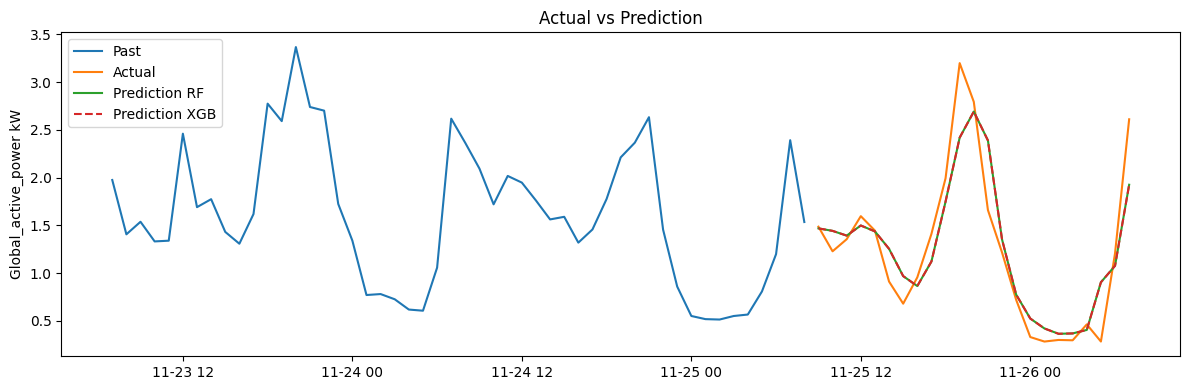

In [281]:
# Extract the last 50 values from y_train and first 23 from y_test
y_train_last = y_train[-50:]
y_test_first = y_test[:23]
pred_rfr_first = pred_rfr[:23]
pred_xgbr_first = pred_xgbr[:23]

# Extract timestamps from the tuple index
y_train_last_index = [ts for _, ts in y_train_last.index]
y_test_first_index = [ts for _, ts in y_test_first.index]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train_last_index, y_train_last.values, label='Past')
plt.plot(y_test_first_index, y_test_first.values, label='Actual')
plt.plot(y_test_first_index, pred_rfr_first, label='Prediction RF')
plt.plot(y_test_first_index, pred_xgbr_first, label='Prediction XGB', linestyle='--')
plt.ylabel('Global_active_power kW')
plt.title('Actual vs Prediction')
plt.legend()
plt.tight_layout()
plt.show()


In [282]:
print(f"Next hour forecast with RF ({X_test.index[0][1]}): {pred_rfr[0]:.3f} kW")
print(f"Next hour forecast with XBGoost ({X_test.index[0][1]}): {pred_xgbr[0]:.3f} kW")
print(f"Next hour real value ({X_test.index[0][1]}): {y_test[0]:.3f} kW")
print(f'Residual difference: {(y_test[0] - pred_rfr[0]):.3f}')

Next hour forecast with RF (2000-11-25 09:00:00): 1.469 kW
Next hour forecast with XBGoost (2000-11-25 09:00:00): 1.469 kW
Next hour real value (2000-11-25 09:00:00): 1.486 kW
Residual difference: 0.018


C:\Users\dcavalei\AppData\Local\Temp\ipykernel_22280\848375315.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Next hour real value ({X_test.index[0][1]}): {y_test[0]:.3f} kW")
C:\Users\dcavalei\AppData\Local\Temp\ipykernel_22280\848375315.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Residual difference: {(y_test[0] - pred_rfr[0]):.3f}')


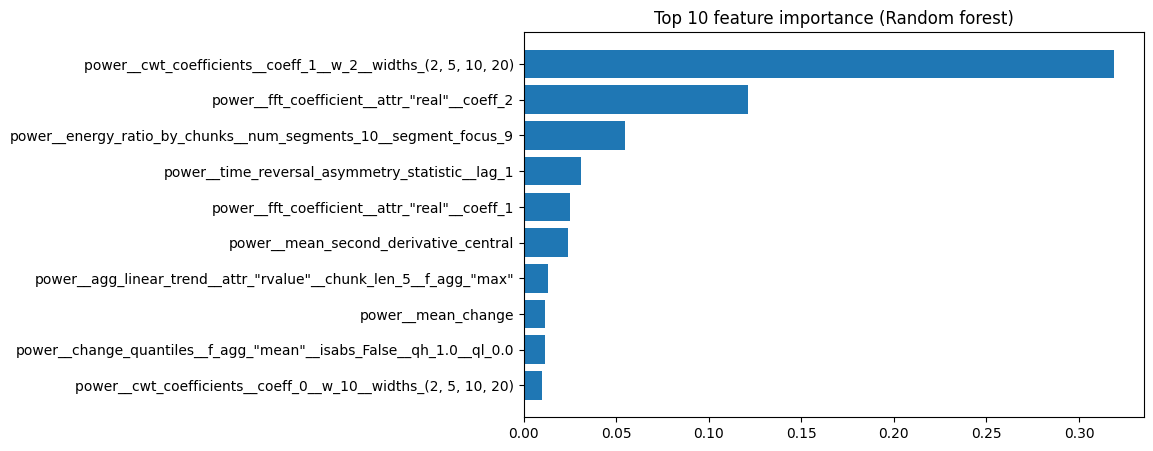

In [283]:
# feature importance

model.feature_importances_.shape
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 10 feature importance (Random forest)')
plt.show()

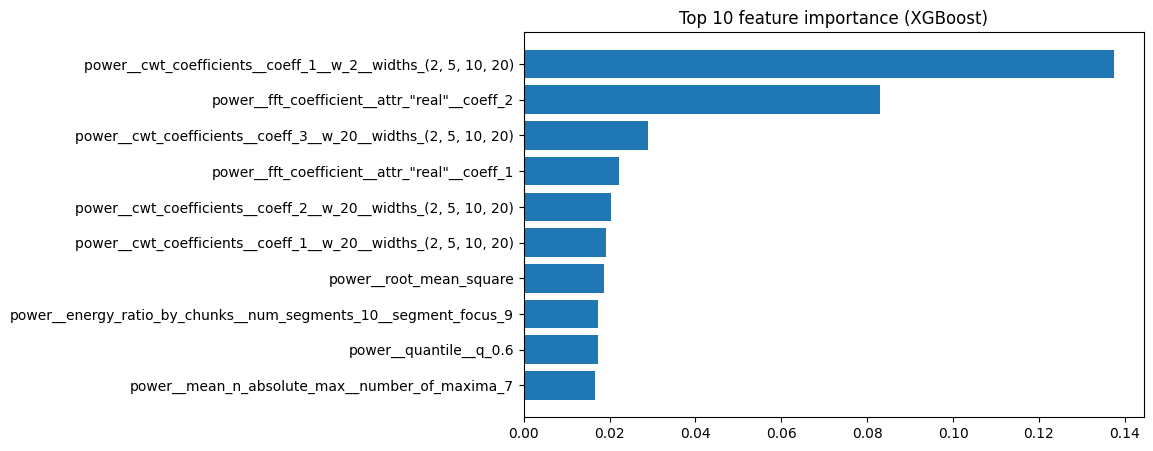

In [284]:
# feature importance

model_xgbr.feature_importances_.shape
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': model_xgbr.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 10 feature importance (XGBoost)')
plt.show()